## 1.0 Collecting our data

Requesting data from the Austin, Texas API using requests.get

Both datasets contain around 160,000 rows of data. To retrieve all the data, using ```?$limit=160000``` at the end of both API endpoints

### 1.1 Requesting data from the intake API and storing as a JSON

In [2]:
import requests
import pandas as pd

response = requests.get('https://data.austintexas.gov/resource/wter-evkm.json?$limit=160000')
data_set1 = response.json()
data_set1

[{'animal_id': 'A665644',
  'datetime': '2013-10-21T07:59:00.000',
  'datetime2': '2013-10-21T07:59:00.000',
  'found_location': 'Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Sick',
  'animal_type': 'Cat',
  'sex_upon_intake': 'Intact Female',
  'age_upon_intake': '4 weeks',
  'breed': 'Domestic Shorthair Mix',
  'color': 'Calico'},
 {'animal_id': 'A665739',
  'name': '*Alana',
  'datetime': '2013-10-22T11:11:00.000',
  'datetime2': '2013-10-22T11:11:00.000',
  'found_location': 'Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Normal',
  'animal_type': 'Cat',
  'sex_upon_intake': 'Intact Female',
  'age_upon_intake': '1 month',
  'breed': 'Domestic Medium Hair Mix',
  'color': 'Black'},
 {'animal_id': 'A665763',
  'datetime': '2013-10-22T15:10:00.000',
  'datetime2': '2013-10-22T15:10:00.000',
  'found_location': 'E Riverside Dr/Royal Crest Dr in Austin (TX)',
  'intake_type': 'Stray',
  'intake_condition': 'Normal',
  'animal_type': 'Dog',
  'sex_upon_

### 1.2 Requesting data from the outcome API and storing as a JSON

In [3]:
response2 = requests.get('https://data.austintexas.gov/resource/9t4d-g238.json?$limit=160000')
data_set2 = response2.json()
data_set2

[{'animal_id': 'A794011',
  'name': 'Chunk',
  'datetime': '2019-05-08T18:20:00.000',
  'monthyear': '2019-05-08T18:20:00.000',
  'date_of_birth': '2017-05-02T00:00:00.000',
  'outcome_type': 'Rto-Adopt',
  'animal_type': 'Cat',
  'sex_upon_outcome': 'Neutered Male',
  'age_upon_outcome': '2 years',
  'breed': 'Domestic Shorthair Mix',
  'color': 'Brown Tabby/White'},
 {'animal_id': 'A776359',
  'name': 'Gizmo',
  'datetime': '2018-07-18T16:02:00.000',
  'monthyear': '2018-07-18T16:02:00.000',
  'date_of_birth': '2017-07-12T00:00:00.000',
  'outcome_type': 'Adoption',
  'animal_type': 'Dog',
  'sex_upon_outcome': 'Neutered Male',
  'age_upon_outcome': '1 year',
  'breed': 'Chihuahua Shorthair Mix',
  'color': 'White/Brown'},
 {'animal_id': 'A821648',
  'datetime': '2020-08-16T11:38:00.000',
  'monthyear': '2020-08-16T11:38:00.000',
  'date_of_birth': '2019-08-16T00:00:00.000',
  'outcome_type': 'Euthanasia',
  'animal_type': 'Other',
  'sex_upon_outcome': 'Unknown',
  'age_upon_outcome

### 1.3 Converting JSON data to a dataframe using PANDAS

In [4]:
# dataframe(df) for intake data
animal_intake_df = pd.DataFrame(data_set1)

# only showing the first 5 rows - can remove .head() to see more rows
animal_intake_df.head(5)


,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
0,A665644,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,NaN
1,A665739,2013-10-22T11:11:00.000,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,*Alana
2,A665763,2013-10-22T15:10:00.000,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,Disciple
4,A634503,2013-10-01T14:49:00.000,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,Otter


In [5]:
# dataframe(df) for outcomes data

animal_outcome_df = pd.DataFrame(data_set2)

animal_outcome_df.head(5)


,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
0,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,NaN
1,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,NaN
2,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,Other,Unknown,1 year,Raccoon,Gray,NaN
3,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,NaN
4,A674754,NaN,2014-03-18T11:47:00.000,2014-03-18T11:47:00.000,2014-03-12T00:00:00.000,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Partner


### 1.4 Writing datasets to csv files

In [6]:
# write intake data to csv
animal_intake_df.to_csv("animal_intake_dataset.csv")

# write outcome data to csv
animal_outcome_df.to_csv("animal_outcome_dataset.csv")


## 2.0 Cleaning the intake dataset

In [7]:
# checking the datatypes of the columns
animal_intake_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154354 entries, 0 to 154353
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         154354 non-null  object
 1   datetime          154354 non-null  object
 2   datetime2         154354 non-null  object
 3   found_location    154354 non-null  object
 4   intake_type       154354 non-null  object
 5   intake_condition  154354 non-null  object
 6   animal_type       154354 non-null  object
 7   sex_upon_intake   154354 non-null  object
 8   age_upon_intake   154354 non-null  object
 9   breed             154354 non-null  object
 10  color             154354 non-null  object
 11  name              109711 non-null  object
dtypes: object(12)
memory usage: 14.1+ MB


### 2.1 Identifying rows with duplicate values in the animal_id and datetime columns in the intakes:

In [8]:
# Identify duplicate rows based on the 'animal_id' and 'datetime' columns:
duplicates_intakes = animal_intake_df[animal_intake_df.duplicated(subset=['animal_id', 'datetime', 'datetime2'], keep=False)]

duplicates_intakes_sorted = duplicates_intakes.sort_values(by=['animal_id', 'datetime'])

In [9]:
# Converting the result into a dataframe and showing the result to observe the duplicates
duplicate_intakes_df = pd.DataFrame(duplicates_intakes_sorted)

duplicate_intakes_df.head(20)

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
19548,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
19549,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
69173,A668183,2014-06-27T11:34:00.000,2014-06-27T11:34:00.000,Austin (TX),Public Assist,Normal,Dog,Spayed Female,10 months,Dachshund Mix,Black/White,Nacha
69174,A668183,2014-06-27T11:34:00.000,2014-06-27T11:34:00.000,Austin (TX),Public Assist,Normal,Dog,Spayed Female,10 months,Dachshund Mix,Black/White,Nacha
99821,A672744,2014-02-17T17:10:00.000,2014-02-17T17:10:00.000,Austin (TX),Public Assist,Normal,Dog,Intact Male,3 years,Rottweiler Mix,Black/Tan,Oso
129158,A672744,2014-02-17T17:10:00.000,2014-02-17T17:10:00.000,Travis (TX),Owner Surrender,Normal,Dog,Intact Male,3 years,Rottweiler Mix,Black/Tan,Oso
70530,A681446,2014-06-16T16:38:00.000,2014-06-16T16:38:00.000,6208 Tupelo Dr in Austin (TX),Wildlife,Normal,Other,Unknown,1 year,Bat,Brown,NaN
70531,A681446,2014-06-16T16:38:00.000,2014-06-16T16:38:00.000,6208 Tupelo Dr in Austin (TX),Wildlife,Normal,Other,Unknown,1 year,Bat,Brown,NaN
75202,A695798,2015-01-23T11:48:00.000,2015-01-23T11:48:00.000,Austin (TX),Owner Surrender,Sick,Cat,Neutered Male,10 months,Domestic Shorthair Mix,Orange,Jim
75203,A695798,2015-01-23T11:48:00.000,2015-01-23T11:48:00.000,Austin (TX),Owner Surrender,Sick,Cat,Neutered Male,10 months,Domestic Shorthair Mix,Orange,Jim


### 2.2 Removing duplicate rows from the intakes df

Removing duplicate rows where the animal_id and datetime values are the same.
Where they are the same, this means the data was inputted twice (probably by mistake) and so removing these duplicate values will ensure the results are not skewed.

In [10]:
# show key features-based duplicates with identical animal_id, datetime, datetime2 (except for first occurrence)
animal_intake_df[animal_intake_df[["animal_id", "datetime", "datetime2"]].duplicated()]

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
6270,A830075,2021-03-02T13:35:00.000,2021-03-02T13:35:00.000,Onion Creek And Pleasant Valley in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Chihuahua Shorthair Mix,Tan,Waffle
8439,A696688,2015-02-10T11:00:00.000,2015-02-10T11:00:00.000,Austin (TX),Owner Surrender,Normal,Cat,Spayed Female,3 years,Domestic Shorthair Mix,Calico/White,Mari
10632,A727043,2016-05-17T15:46:00.000,2016-05-17T15:46:00.000,9515 N Lamar Blvd in Austin (TX),Stray,Normal,Cat,Intact Male,1 year,Domestic Shorthair Mix,Blue/White,*Larry
14605,A866229,2022-09-26T15:17:00.000,2022-09-26T15:17:00.000,9301 Hog Eye Rd in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair,Orange Tabby,*Jones
15314,A761936,2017-11-12T11:16:00.000,2017-11-12T11:16:00.000,8400 Old Bee Caves in Austin (TX),Stray,Normal,Dog,Intact Male,9 months,Scottish Terrier Mix,Brown Brindle,NaN
16681,A863452,2022-08-31T11:55:00.000,2022-08-31T11:55:00.000,4200 Brookview in Austin (TX),Stray,Normal,Dog,Intact Female,10 months,German Shepherd,White,Amber
19549,A561806,2017-06-05T11:36:00.000,2017-06-05T11:36:00.000,2002 Nightview in Austin (TX),Stray,Normal,Dog,Spayed Female,8 years,Pit Bull Mix,Brown Brindle/White,Dasia
31779,A773428,2018-05-31T18:38:00.000,2018-05-31T18:38:00.000,7Th And Gonzalez in Austin (TX),Stray,Normal,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Orange Tabby,*Atreyu
51141,A815987,2020-04-09T15:32:00.000,2020-04-09T15:32:00.000,Austin (TX),Public Assist,Normal,Dog,Intact Female,1 year,Cairn Terrier,White/Brown,Princess
55069,A735395,2016-09-23T12:00:00.000,2016-09-23T12:00:00.000,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,10 months,Domestic Shorthair Mix,Brown Tabby,Owl


In [11]:
# delete duplicates and save changes to existing dataframe
animal_intake_df.drop_duplicates(subset=['animal_id', 'datetime', 'datetime2'], inplace=True)
animal_intake_df

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name
0,A665644,2013-10-21T07:59:00.000,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,NaN
1,A665739,2013-10-22T11:11:00.000,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,*Alana
2,A665763,2013-10-22T15:10:00.000,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,Disciple
4,A634503,2013-10-01T14:49:00.000,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,Otter
...,...,...,...,...,...,...,...,...,...,...,...,...
154349,A886695,2023-08-09T13:30:00.000,2023-08-09T13:30:00.000,Bethune Avenue & East Saint Johns Avenue in Au...,Stray,Sick,Cat,Unknown,1 month,Domestic Shorthair,Black,NaN
154350,A882170,2023-08-09T12:02:00.000,2023-08-09T12:02:00.000,Travis (TX),Owner Surrender,Injured,Dog,Spayed Female,9 months,Labrador Retriever/Pit Bull,Black/White,Osa
154351,A886577,2023-08-08T09:03:00.000,2023-08-08T09:03:00.000,5901 Municipal Complex in Lago Vista (TX),Stray,Normal,Dog,Intact Male,4 years,Shiba Inu/German Shepherd,Black/Tan,NaN
154352,A886696,2023-08-09T13:30:00.000,2023-08-09T13:30:00.000,Bethune Avenue & East Saint Johns Avenue in Au...,Stray,Sick,Cat,Unknown,1 month,Domestic Shorthair,White/Black,NaN


### 2.3 Removing duplicate columns from the intakes df

The dataset contains two seemingly identical columns for datetime of intake: datetime and datetime2. Confirm that these are in fact duplicates, then delete duplicate columns and replace with a more appropriately named intake_date column.

In [12]:
# checking to ensure datetime and datetime2 are identical for all records
animal_intake_df[~(animal_intake_df["datetime"] == animal_intake_df["datetime2"])]

,animal_id,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,name


In [13]:
# storing the datetime column data into a variable intake_date
intake_date = animal_intake_df['datetime']

# using the PANDAS drop function to drop the 'datetime' and 'datetime2' columns from the intake dataset
intake_df = animal_intake_df.drop(['datetime', 'datetime2'], axis='columns')

# inserting the new column which we created above (intake_date) and placing this at index 1 in the dataframe
intake_df.insert(1, 'intake_date', intake_date)

intake_df.shape


(154321, 11)

## 3.0 Cleaning the outcome dataset

Repeat the process that was completed above in the intakes df for the outcomes dataset

### 3.1 Removing duplicate rows from the outcome df

Removing duplicate rows where the animal_id and datetime values are the same.
Where they are the same, this means the data was inputted twice (probably by mistake) and so removing these duplicate values will ensure the results are not skewed.

In [14]:
# show key features-based duplicates with identical animal_id, datetime, monthyear (except for first occurrence)
animal_outcome_df[animal_outcome_df[["animal_id", "datetime", "monthyear"]].duplicated()]

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
9764,A815987,Princess,2020-04-13T16:56:00.000,2020-04-13T16:56:00.000,2019-04-02T00:00:00.000,Return to Owner,Dog,Intact Female,1 year,Cairn Terrier,White/Brown,NaN
18140,A761936,NaN,2017-11-16T12:54:00.000,2017-11-16T12:54:00.000,2017-01-12T00:00:00.000,Transfer,Dog,Intact Male,10 months,Scottish Terrier Mix,Brown Brindle,Partner
25842,A783234,Princess,2019-01-13T16:39:00.000,2019-01-13T16:39:00.000,2016-10-27T00:00:00.000,Rto-Adopt,Dog,Spayed Female,2 years,Collie Smooth/Pointer,Brown,NaN
40082,A846569,A846569,2021-12-04T10:34:00.000,2021-12-04T10:34:00.000,2021-06-15T00:00:00.000,Adoption,Dog,Neutered Male,5 months,Australian Cattle Dog Mix,Red Tick,NaN
54832,A682781,NaN,2014-07-03T09:00:00.000,2014-07-03T09:00:00.000,2013-01-02T00:00:00.000,Transfer,Cat,Neutered Male,1 year,Domestic Shorthair Mix,White/Black,SCRP
61064,A683782,NaN,2014-07-16T09:00:00.000,2014-07-16T09:00:00.000,2014-02-15T00:00:00.000,Transfer,Cat,Neutered Male,4 months,Domestic Shorthair Mix,Brown Tabby,SCRP
69588,A686827,NaN,2014-08-28T09:00:00.000,2014-08-28T09:00:00.000,2012-02-27T00:00:00.000,Transfer,Cat,Spayed Female,2 years,Domestic Shorthair Mix,Calico,SCRP
80360,A755687,NaN,2017-08-07T13:50:00.000,2017-08-07T13:50:00.000,2014-08-07T00:00:00.000,Disposal,Other,Unknown,3 years,Bat Mix,Brown,NaN
81889,A660948,*Roy,2013-11-03T18:16:00.000,2013-11-03T18:16:00.000,2013-07-08T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Domestic Shorthair Mix,Brown Tabby/White,NaN
90698,A866229,*Jones,2022-10-29T11:16:00.000,2022-10-29T11:16:00.000,2022-08-07T00:00:00.000,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair,Orange Tabby,NaN


In [15]:
# delete duplicates and save changes to existing dataframe
animal_outcome_df.drop_duplicates(subset=['animal_id', 'datetime', 'monthyear'], inplace=True)
animal_outcome_df

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
0,A794011,Chunk,2019-05-08T18:20:00.000,2019-05-08T18:20:00.000,2017-05-02T00:00:00.000,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,NaN
1,A776359,Gizmo,2018-07-18T16:02:00.000,2018-07-18T16:02:00.000,2017-07-12T00:00:00.000,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown,NaN
2,A821648,NaN,2020-08-16T11:38:00.000,2020-08-16T11:38:00.000,2019-08-16T00:00:00.000,Euthanasia,Other,Unknown,1 year,Raccoon,Gray,NaN
3,A720371,Moose,2016-02-13T17:59:00.000,2016-02-13T17:59:00.000,2015-10-08T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff,NaN
4,A674754,NaN,2014-03-18T11:47:00.000,2014-03-18T11:47:00.000,2014-03-12T00:00:00.000,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,Partner
...,...,...,...,...,...,...,...,...,...,...,...,...
154220,A859974,*Lady Gaga,2022-08-16T11:42:00.000,2022-08-16T11:42:00.000,2012-06-21T00:00:00.000,Adoption,Cat,Spayed Female,10 years,Devon Rex,White,NaN
154221,A856973,*Suede,2022-06-11T15:39:00.000,2022-06-11T15:39:00.000,2021-05-10T00:00:00.000,Adoption,Cat,Spayed Female,1 year,Domestic Medium Hair,Blue,NaN
154222,A852036,Queen,2022-03-17T17:22:00.000,2022-03-17T17:22:00.000,2021-12-08T00:00:00.000,Adoption,Dog,Spayed Female,3 months,German Shepherd Mix,Brown/Black,NaN
154223,A852775,A852775,2022-05-18T14:13:00.000,2022-05-18T14:13:00.000,2022-01-31T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Tortie,Foster


### 3.2 Removing duplicate columns from the outcomes df

The dataset contains two seemingly identical columns for datetime of intake: datetime and monthyear. Confirm that these are in fact duplicates, then delete duplicate columns and replace with a more appropriately named intake_date column.

In [16]:
# checking to ensure datetime and monthyear are identical for all records
animal_outcome_df[~(animal_outcome_df["datetime"] == animal_outcome_df["monthyear"])]

,animal_id,name,datetime,monthyear,date_of_birth,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype


In [17]:
# storing the datetime column data into a variable outcome date
outcome_date = animal_outcome_df['datetime']

# using the PANDAS drop function to drop the 'datetime' and 'monthyear' columns from the outcome dataset
outcome_df = animal_outcome_df.drop(['datetime', 'monthyear'], axis='columns')

# inserting the new column which we created above (outcome_date) and placing this at index 1 in the dataframe
outcome_df.insert(1, 'outcome_date', outcome_date)

outcome_df.shape

(154203, 11)

## 4.0 Merging intake and outcome dataframes

For ease of analysis, the outcome and intake dataframes are merged. We choose to perform an inner join on animal_id to limit the data that we work with to those animals where there is information about both their intake and their ultimate outcome.

In [18]:
# merging dataframes based on animal_id
shelter_df = pd.merge(intake_df, outcome_df, how='inner', on='animal_id', suffixes=['_outcomes', '_intakes'])

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
0,A665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,...,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,Partner
1,A665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,A665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,A379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,...,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Pit Bull,Black,NaN
4,A634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,...,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,A886572,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-08T19:17:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,Partner
197611,A884257,2023-06-30T13:27:00.000,6907 Bitteroot Trl in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair,Black/White,...,2023-08-08T18:10:00.000,Leo,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Domestic Shorthair,Black/White,NaN
197612,A886574,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Cat,Intact Male,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-08T19:18:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Domestic Shorthair,Brown Tabby,Partner
197613,A886649,2023-08-08T18:52:00.000,Springdale in Austin (TX),Stray,Normal,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-09T12:49:00.000,886649,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,Partner


## 5.0 Cleaning merged dataframe

### 5.1 Converting animal_id to data type integer

Remove the "A" at the beginning of the animal_id by using regex. We can then turn the animal_id into an integer data type for ease of sorting and manipulation.

In [19]:
# Use of regex to remove the A in animal_id, rather than using string slicing as if the code is run multiple times, then will remove a value each time
shelter_df['animal_id'] = shelter_df['animal_id'].str.replace(r'A', '', regex=True).astype(int)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,...,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Domestic Shorthair Mix,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Dog,Intact Male,10 years,Pit Bull,Black,...,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Pit Bull,Black,NaN
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,...,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Norfolk Terrier Mix,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-08T19:17:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,Partner
197611,884257,2023-06-30T13:27:00.000,6907 Bitteroot Trl in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Shorthair,Black/White,...,2023-08-08T18:10:00.000,Leo,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Domestic Shorthair,Black/White,NaN
197612,886574,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Cat,Intact Male,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-08T19:18:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Domestic Shorthair,Brown Tabby,Partner
197613,886649,2023-08-08T18:52:00.000,Springdale in Austin (TX),Stray,Normal,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,...,2023-08-09T12:49:00.000,886649,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Domestic Shorthair,Brown Tabby,Partner


### 5.2 Removing duplicate and unneeded columns

The two datasets had some columns that we thought might contain the exact same data, thereby introducing duplicates upon the merge. We checked these columns to confirm if the data was in fact duplicate, then deleted duplicates accordingly.

In [20]:
# Confirm that color_outcomes and color_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["color_outcomes"] == shelter_df["color_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [21]:
# Confirm that breed_outcomes and breed_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["breed_outcomes"] == shelter_df["breed_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [22]:
# Confirm that animal_type_outcomes and animal_type_intakes are duplicates (result confirms duplication)
shelter_df[~(shelter_df["animal_type_outcomes"] == shelter_df["animal_type_intakes"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype


In [23]:
# Cheking if sex_upon_outcome and sex_upon_intake are duplicates (result confirms NOT duplicated)
shelter_df[~(shelter_df["sex_upon_outcome"] == shelter_df["sex_upon_intake"])]

,animal_id,intake_date,found_location,intake_type,intake_condition,animal_type_outcomes,sex_upon_intake,age_upon_intake,breed_outcomes,color_outcomes,...,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,breed_intakes,color_intakes,outcome_subtype
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Medium Hair Mix,Black,...,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Medium Hair Mix,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Cairn Terrier Mix,Tan/White,...,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Cairn Terrier Mix,Tan/White,NaN
7,664936,2013-10-11T11:20:00.000,501 U.S. 183 in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,Domestic Medium Hair Mix,Brown Tabby,...,2013-12-18T18:18:00.000,*Jester,2013-08-18T00:00:00.000,Adoption,Cat,Neutered Male,4 months,Domestic Medium Hair Mix,Brown Tabby,NaN
12,664887,2013-10-10T13:48:00.000,1901 Onion Creek Pkwy in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair Mix,Black,...,2013-11-10T16:56:00.000,*Gia,2013-08-10T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Black,NaN
13,665800,2013-10-23T11:08:00.000,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,3 months,Domestic Shorthair Mix,Tortie,...,2013-11-10T18:50:00.000,*Precious,2013-07-23T00:00:00.000,Transfer,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Tortie,Partner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197603,885370,2023-07-18T14:58:00.000,10705 Daryl Cove in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair,Calico/White,...,2023-08-08T16:32:00.000,Egg Nog,2023-05-28T00:00:00.000,Adoption,Cat,Spayed Female,2 months,Domestic Shorthair,Calico/White,NaN
197604,885802,2023-07-25T16:43:00.000,Fm 969 And Bantom Woods Road in Austin (TX),Stray,Normal,Cat,Intact Male,2 months,Domestic Shorthair,Orange Tabby,...,2023-08-08T17:27:00.000,Neville,2023-05-22T00:00:00.000,Adoption,Cat,Neutered Male,2 months,Domestic Shorthair,Orange Tabby,NaN
197605,885797,2023-07-25T16:43:00.000,Fm 969 And Bantom Woods Road in Austin (TX),Stray,Normal,Cat,Intact Female,2 months,Domestic Shorthair,Calico,...,2023-08-08T17:27:00.000,Luna,2023-05-22T00:00:00.000,Adoption,Cat,Spayed Female,2 months,Domestic Shorthair,Calico,NaN
197606,882008,2023-05-30T13:18:00.000,12011 Yanez Drive in Travis (TX),Stray,Normal,Cat,Intact Female,1 year,Domestic Shorthair,Brown Tabby,...,2023-08-08T16:57:00.000,Pumpkin,2022-05-30T00:00:00.000,Adoption,Cat,Spayed Female,1 year,Domestic Shorthair,Brown Tabby,NaN


In [24]:
# Removing duplicate columns
shelter_df.drop(['color_outcomes',
                'breed_intakes',
                'animal_type_outcomes'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,found_location,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,name_outcomes,outcome_date,name_intakes,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Austin (TX),Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,NaN,2013-10-21T11:39:00.000,NaN,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Austin (TX),Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,*Alana,2013-12-20T17:36:00.000,*Alana,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,E Riverside Dr/Royal Crest Dr in Austin (TX),Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,NaN,2013-10-26T18:32:00.000,NaN,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,51St And Grover in Austin (TX),Stray,Normal,Intact Male,10 years,Pit Bull,Disciple,2013-10-25T12:53:00.000,Disciple,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN
4,634503,2013-10-01T14:49:00.000,Manor (TX),Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,Otter,2013-10-02T12:40:00.000,Otter,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Intact Female,2 weeks,Domestic Shorthair,NaN,2023-08-08T19:17:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner
197611,884257,2023-06-30T13:27:00.000,6907 Bitteroot Trl in Austin (TX),Stray,Normal,Intact Male,1 month,Domestic Shorthair,Leo,2023-08-08T18:10:00.000,Leo,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Black/White,NaN
197612,886574,2023-08-08T08:29:00.000,1004 West Ave in Austin (TX),Stray,Neonatal,Intact Male,2 weeks,Domestic Shorthair,NaN,2023-08-08T19:18:00.000,NaN,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Brown Tabby,Partner
197613,886649,2023-08-08T18:52:00.000,Springdale in Austin (TX),Stray,Normal,Intact Female,2 weeks,Domestic Shorthair,886649,2023-08-09T12:49:00.000,886649,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner



Separately, there are some columns in the merged dataframe that are not helpful for our analysis. These include name_intakes, name_outcomes, and found_location. We remove these columns.

In [25]:
# Removing columns that we do not need for our analysis
shelter_df.drop(['name_intakes',
                'name_outcomes',
                'found_location'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN
3,379998,2013-10-23T11:42:00.000,Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN
4,634503,2013-10-01T14:49:00.000,Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Female,2 weeks,Domestic Shorthair,2023-08-08T19:17:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner
197611,884257,2023-06-30T13:27:00.000,Stray,Normal,Intact Male,1 month,Domestic Shorthair,2023-08-08T18:10:00.000,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Black/White,NaN
197612,886574,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Male,2 weeks,Domestic Shorthair,2023-08-08T19:18:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Brown Tabby,Partner
197613,886649,2023-08-08T18:52:00.000,Stray,Normal,Intact Female,2 weeks,Domestic Shorthair,2023-08-09T12:49:00.000,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner


### 5.3 Removing unnecessary records
We remove unnecessary records from our dataset that are not directly relevant to our primary goal of increasing adoption rates. As we know there are some animals that come under the category of livestock and wildlife, we will check how many of the animals were adopted and if there is an insufficient amount of data, the rows will be removed. 

In [26]:
# Check adoptions by intake_type
shelter_df.groupby(["intake_type", "outcome_type"])["outcome_type"].count()

intake_type         outcome_type   
Abandoned           Adoption             791
                    Died                   7
                    Disposal               5
                    Euthanasia             8
                    Missing                1
                    Return to Owner      163
                    Rto-Adopt             28
                    Transfer             369
Euthanasia Request  Adoption              22
                    Died                   3
                    Disposal               2
                    Euthanasia           203
                    Return to Owner       17
                    Transfer              37
Owner Surrender     Adoption           32595
                    Died                 215
                    Disposal              15
                    Euthanasia           914
                    Missing               16
                    Return to Owner     3249
                    Rto-Adopt            523
                   

In [27]:
# Examine wildlife that was adopted
shelter_df[(shelter_df["intake_type"] == "Wildlife") & (shelter_df["outcome_type"] == "Adoption")]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
38763,727224,2016-05-20T09:28:00.000,Wildlife,Normal,Intact Female,5 years,Peafowl Mix,2016-06-12T09:39:00.000,2011-05-20T00:00:00.000,Adoption,Bird,Intact Female,5 years,Brown/Green,Foster
48082,746727,2017-04-08T11:43:00.000,Wildlife,Normal,Unknown,1 year,Parakeet,2017-04-12T14:20:00.000,2016-04-08T00:00:00.000,Adoption,Bird,Unknown,1 year,Blue/Black,NaN
112322,773691,2018-06-04T13:06:00.000,Wildlife,Normal,Intact Female,3 years,Parakeet Mix,2018-06-08T11:02:00.000,2015-06-04T00:00:00.000,Adoption,Bird,Intact Female,3 years,White/Blue,NaN
150077,773472,2018-06-01T14:06:00.000,Wildlife,Normal,Intact Female,3 years,Peafowl Mix,2018-06-15T10:50:00.000,2015-06-01T00:00:00.000,Adoption,Bird,Intact Female,3 years,Gray/Green,Foster
170314,828091,2021-01-07T11:52:00.000,Wildlife,Normal,Unknown,1 year,Parakeet,2021-01-19T10:46:00.000,2020-01-07T00:00:00.000,Adoption,Bird,Unknown,1 year,Green/Yellow,Foster
172102,828092,2021-01-07T11:52:00.000,Wildlife,Normal,Unknown,1 year,Parakeet,2021-01-19T10:46:00.000,2020-01-07T00:00:00.000,Adoption,Bird,Unknown,1 year,Green/Yellow,Foster
181473,730336,2016-07-02T12:36:00.000,Wildlife,Normal,Intact Female,1 year,Rabbit Lh Mix,2016-09-10T13:58:00.000,2015-07-02T00:00:00.000,Adoption,Other,Spayed Female,1 year,White,NaN


In [28]:
# Check adoptions by animal type
shelter_df.groupby(["animal_type_intakes", "outcome_type"])["outcome_type"].count()

animal_type_intakes  outcome_type   
Bird                 Adoption             261
                     Died                  29
                     Disposal              31
                     Euthanasia           139
                     Missing                1
                     Relocate              10
                     Return to Owner       54
                     Transfer             239
Cat                  Adoption           33196
                     Died                 865
                     Disposal             108
                     Euthanasia          2356
                     Missing               43
                     Relocate               6
                     Return to Owner     3181
                     Rto-Adopt            262
                     Transfer           25040
Dog                  Adoption           59621
                     Died                 375
                     Disposal              73
                     Euthanasia          23

In [29]:
# Examine livestock that was adopted
shelter_df[(shelter_df["animal_type_intakes"] == "Livestock") & (shelter_df["outcome_type"] == "Adoption")]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
34118,778971,2018-08-23T13:46:00.000,Stray,Normal,Intact Female,4 months,Pig Mix,2019-04-02T11:35:00.000,2018-04-23T00:00:00.000,Adoption,Livestock,Intact Female,11 months,Gray/Black,Foster
38699,674214,2014-03-09T16:45:00.000,Stray,Normal,Unknown,2 weeks,Pig Mix,2014-03-29T14:00:00.000,2014-02-22T00:00:00.000,Adoption,Livestock,Unknown,5 weeks,Black,Foster
53553,808936,2019-11-16T13:10:00.000,Stray,Normal,Unknown,3 months,Pig,2021-08-12T10:06:00.000,2019-08-16T00:00:00.000,Adoption,Livestock,Unknown,1 year,Pink,Foster
54587,778432,2018-08-14T16:32:00.000,Stray,Normal,Intact Female,3 months,Pig Mix,2019-04-02T11:35:00.000,2018-05-14T00:00:00.000,Adoption,Livestock,Intact Female,10 months,White/Black,Foster
118668,811675,2020-01-07T15:56:00.000,Stray,Normal,Intact Female,2 years,Goat,2020-07-22T11:46:00.000,2018-01-07T00:00:00.000,Adoption,Livestock,Intact Female,2 years,Black/White,Foster
121686,808934,2019-11-16T13:10:00.000,Stray,Normal,Unknown,3 months,Pig,2020-08-21T13:25:00.000,2019-08-16T00:00:00.000,Adoption,Livestock,Unknown,1 year,Pink,Foster
138759,769204,2018-04-01T12:18:00.000,Stray,Normal,Intact Male,5 months,Sheep Mix,2019-03-26T10:32:00.000,2017-10-01T00:00:00.000,Adoption,Livestock,Intact Male,1 year,Black/White,Foster
140550,841166,2021-08-22T12:38:00.000,Stray,Normal,Unknown,2 years,Potbelly Pig,2021-09-08T17:04:00.000,2019-08-22T00:00:00.000,Adoption,Livestock,Unknown,2 years,Tan,Offsite
154372,808935,2019-11-16T13:10:00.000,Stray,Normal,Unknown,3 months,Pig,2021-08-12T10:06:00.000,2019-08-16T00:00:00.000,Adoption,Livestock,Unknown,1 year,Pink,Foster
161338,673651,2014-02-28T11:06:00.000,Stray,Normal,Neutered Male,1 year,Pig Mix,2014-03-11T14:39:00.000,2013-02-28T00:00:00.000,Adoption,Livestock,Neutered Male,1 year,Black/White,Foster


As expected, there are a a few amount of wildlife and livestock animals that were adopted and due to this, we will remove these rows from our dataset. 

In [30]:
# Deleting rows that contain Livestock animal data
shelter_df.drop(shelter_df[shelter_df["animal_type_intakes"] == "Livestock"].index, inplace=True)

shelter_df[shelter_df["animal_type_intakes"] == "Livestock"]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype


In [31]:
# Deleting rows that contain Wildlife animal data
shelter_df.drop(shelter_df[shelter_df["animal_type_intakes"] == "Wildlife"].index, inplace=True)

shelter_df[shelter_df["animal_type_intakes"] == "Wildlife"]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype


When we looked at the aoutcome type for the animals, there was an outcome type 'RTO-adopt'. After doing some research there is no clear answer as to what this may mean.
Therefore, we removed the rows of data where to outcome type included RTO-Adopt to avoid confusion when wanting to look at adoption rates during the analysis as it is not clear if these animals were adopted or returned to their owner. 

In [32]:
shelter_df.drop(shelter_df[shelter_df["outcome_type"] == "Rto-Adopt"].index, inplace=True)

shelter_df[shelter_df["outcome_type"] == "Rto-Adopt"]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype


### 5.4 Removing whitespaces

The data in our datasets are likely to be input by users. To ensure that leading and trailing whitespaces do not interfere with our analysis, we define a lambda function to remove them using the .apply method.

In [33]:
# look for columns with datatype object and strip any leading/trailing spaces
shelter_df.apply(lambda value: value.str.strip() if value.dtype == "object" else value)

shelter_df.head(3)

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype
0,665644,2013-10-21T07:59:00.000,Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner
1,665739,2013-10-22T11:11:00.000,Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster
2,665763,2013-10-22T15:10:00.000,Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN


## 6.0 Additional data manipulation to prepare for analysis

We identified several ways that the data needed to be manipulated to prepare it for our analysis.

### 6.1 Extracting sex and neuter status into separate columns
One of our observations was that the sex_upon_intake and sex_upon_outcome contain the sex of the animal as well as their neuter status. What is important for our analysis is sex of each animal as well as neuter status at the time of outcome. We prepare our data by (i) seperating sex into separate columns for both intake and outcome, (ii) comparing the values to confirm they are the same, then (iii) deleting one of the duplicate columns. For neuter status, we create a new column for neuter status at outcome.

In [34]:
# using regex to return values about neuturing into new columns -
# this is done by extracting the word before the white space as can see from the data that there is a space between the neuteruing and gender of animal
shelter_df['Neuter Status at Outcome'] = shelter_df['sex_upon_outcome'].str.extract('(\w*\s)', expand=True)

# using regex to return the sex of the animal at intake and outcome in new columns
shelter_df['Sex at Intake'] = shelter_df['sex_upon_intake'].str.extract(('[^ ]* (.*)'), expand=True)
shelter_df['Sex at Outcome'] = shelter_df['sex_upon_outcome'].str.extract(('[^ ]* (.*)'), expand=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Sex at Outcome
0,665644,2013-10-21T07:59:00.000,Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner,Intact,Female,Female
1,665739,2013-10-22T11:11:00.000,Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster,Spayed,Female,Female
2,665763,2013-10-22T15:10:00.000,Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN,Neutered,Male,Male
3,379998,2013-10-23T11:42:00.000,Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN,Intact,Male,Male
4,634503,2013-10-01T14:49:00.000,Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN,Spayed,Female,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Female,2 weeks,Domestic Shorthair,2023-08-08T19:17:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner,Intact,Female,Female
197611,884257,2023-06-30T13:27:00.000,Stray,Normal,Intact Male,1 month,Domestic Shorthair,2023-08-08T18:10:00.000,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Black/White,NaN,Neutered,Male,Male
197612,886574,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Male,2 weeks,Domestic Shorthair,2023-08-08T19:18:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Brown Tabby,Partner,Intact,Male,Male
197613,886649,2023-08-08T18:52:00.000,Stray,Normal,Intact Female,2 weeks,Domestic Shorthair,2023-08-09T12:49:00.000,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner,Intact,Female,Female


Some values in these new columns are missing, so we replace NaN values with "Unknown"

In [35]:
# adding the string Unknown into as the value for new columns that contain NaN
shelter_df[['Sex at Intake', 'Sex at Outcome', 'Neuter Status at Outcome']] = shelter_df[['Sex at Intake', 'Sex at Outcome', 'Neuter Status at Outcome']].fillna('Unknown')

shelter_df

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Sex at Outcome
0,665644,2013-10-21T07:59:00.000,Stray,Sick,Intact Female,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,Intact Female,4 weeks,Calico,Partner,Intact,Female,Female
1,665739,2013-10-22T11:11:00.000,Stray,Normal,Intact Female,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,Spayed Female,3 months,Black,Foster,Spayed,Female,Female
2,665763,2013-10-22T15:10:00.000,Stray,Normal,Intact Male,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,Neutered Male,4 months,Tan/White,NaN,Neutered,Male,Male
3,379998,2013-10-23T11:42:00.000,Stray,Normal,Intact Male,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,Intact Male,10 years,Black,NaN,Intact,Male,Male
4,634503,2013-10-01T14:49:00.000,Owner Surrender,Normal,Spayed Female,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,Spayed Female,2 years,Tan,NaN,Spayed,Female,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Female,2 weeks,Domestic Shorthair,2023-08-08T19:17:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner,Intact,Female,Female
197611,884257,2023-06-30T13:27:00.000,Stray,Normal,Intact Male,1 month,Domestic Shorthair,2023-08-08T18:10:00.000,2023-04-30T00:00:00.000,Adoption,Cat,Neutered Male,3 months,Black/White,NaN,Neutered,Male,Male
197612,886574,2023-08-08T08:29:00.000,Stray,Neonatal,Intact Male,2 weeks,Domestic Shorthair,2023-08-08T19:18:00.000,2023-07-20T00:00:00.000,Transfer,Cat,Intact Male,2 weeks,Brown Tabby,Partner,Intact,Male,Male
197613,886649,2023-08-08T18:52:00.000,Stray,Normal,Intact Female,2 weeks,Domestic Shorthair,2023-08-09T12:49:00.000,2023-07-24T00:00:00.000,Transfer,Cat,Intact Female,2 weeks,Brown Tabby,Partner,Intact,Female,Female


In [36]:
# Confirm that sex at intake and sex at outcome are the same for each record (result confirms these columns are duplicates)
shelter_df[~(shelter_df["Sex at Intake"] == shelter_df["Sex at Outcome"])]

,animal_id,intake_date,intake_type,intake_condition,sex_upon_intake,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,sex_upon_outcome,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Sex at Outcome


In [37]:
# Delete duplicate column as well as source columns which are no longer needed
shelter_df.drop(['Sex at Outcome',
                'sex_upon_outcome',
                'sex_upon_intake'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake
0,665644,2013-10-21T07:59:00.000,Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21T11:39:00.000,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Female
1,665739,2013-10-22T11:11:00.000,Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20T17:36:00.000,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Spayed,Female
2,665763,2013-10-22T15:10:00.000,Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26T18:32:00.000,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Neutered,Male
3,379998,2013-10-23T11:42:00.000,Stray,Normal,10 years,Pit Bull,2013-10-25T12:53:00.000,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Male
4,634503,2013-10-01T14:49:00.000,Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02T12:40:00.000,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08T08:29:00.000,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08T19:17:00.000,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female
197611,884257,2023-06-30T13:27:00.000,Stray,Normal,1 month,Domestic Shorthair,2023-08-08T18:10:00.000,2023-04-30T00:00:00.000,Adoption,Cat,3 months,Black/White,NaN,Neutered,Male
197612,886574,2023-08-08T08:29:00.000,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08T19:18:00.000,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Male
197613,886649,2023-08-08T18:52:00.000,Stray,Normal,2 weeks,Domestic Shorthair,2023-08-09T12:49:00.000,2023-07-24T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female


### 6.2 Calculating each animal's length of stay at the shelter

We can find the amount of time each animal spent in the shelter and store this in a new column. For this calculation, we convert the intake_date and outcome_date columns to datetime using the `to_datetime` function, then subtract the outcome date by the intake date.

In [38]:
shelter_df['intake_date'] = pd.to_datetime(shelter_df['intake_date'])
shelter_df['outcome_date'] = pd.to_datetime(shelter_df['outcome_date'])
shelter_df['Time In Shelter'] = shelter_df['outcome_date'] - shelter_df['intake_date']
shelter_df

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:17:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 10:48:00
197611,884257,2023-06-30 13:27:00,Stray,Normal,1 month,Domestic Shorthair,2023-08-08 18:10:00,2023-04-30T00:00:00.000,Adoption,Cat,3 months,Black/White,NaN,Neutered,Male,39 days 04:43:00
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:18:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Male,0 days 10:49:00
197613,886649,2023-08-08 18:52:00,Stray,Normal,2 weeks,Domestic Shorthair,2023-08-09 12:49:00,2023-07-24T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 17:57:00


We can now get a sense of the distribution in our data by using the describe function.


In [39]:
shelter_df.describe()

,animal_id,intake_date,outcome_date,Time In Shelter
count,195665.000000,195665,195665,195665
mean,754701.282662,2018-02-16 10:53:06.342984192,2018-03-07 04:52:35.378734336,18 days 17:59:29.035749878
min,6100.000000,2013-10-01 07:51:00,2013-10-01 10:39:00,-3536 days +06:54:00
25%,705212.000000,2015-11-09 11:46:00,2015-11-29 14:02:00,0 days 21:03:00
50%,752894.000000,2017-12-07 10:46:00,2017-12-24 13:36:00,5 days 06:46:00
75%,804899.000000,2019-12-10 10:17:00,2020-01-02 10:48:00,26 days 05:22:00
max,886891.000000,2023-08-12 13:56:00,2023-08-12 14:29:00,3550 days 22:05:00
std,69826.992342,NaN,NaN,282 days 10:04:56.616720732


This shows the minimum time in shelter is negative. Where the time in shelter is negative, the intake date is more recent then the outcome date. We check for records where the intake date is after the outcome date.

In [40]:
# check for occurrences where intake date is after outcome date (suggesting data input error)
incorrect_dates = shelter_df[shelter_df['intake_date'] >= shelter_df['outcome_date']]

incorrect_dates

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter
16,645345,2018-05-12 14:07:00,Owner Surrender,Normal,6 years,Pit Bull Mix,2013-10-20 16:29:00,2012-01-06T00:00:00.000,Transfer,Dog,1 year,Brown/White,Partner,Spayed,Female,-1665 days +02:22:00
26,665923,2016-07-16 18:07:00,Public Assist,Normal,4 years,German Shepherd/Labrador Retriever,2013-11-04 15:00:00,2012-04-24T00:00:00.000,Return to Owner,Dog,1 year,Red,NaN,Spayed,Female,-986 days +20:53:00
44,664439,2013-12-16 14:07:00,Stray,Normal,6 months,Dachshund/Rat Terrier,2013-10-10 16:39:00,2013-06-03T00:00:00.000,Adoption,Dog,4 months,White/Black,NaN,Neutered,Male,-67 days +02:32:00
56,665874,2014-01-12 08:30:00,Stray,Normal,11 months,Pit Bull Mix,2013-10-24 14:30:00,2013-01-13T00:00:00.000,Return to Owner,Dog,9 months,Brown/White,NaN,Neutered,Male,-80 days +06:00:00
57,665874,2016-11-09 12:01:00,Stray,Normal,3 years,Pit Bull Mix,2014-01-13 12:40:00,2013-01-13T00:00:00.000,Return to Owner,Dog,1 year,Brown/White,NaN,Neutered,Male,-1031 days +00:39:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197544,875525,2023-07-23 21:47:00,Public Assist,Normal,8 months,Domestic Shorthair,2023-03-07 17:31:00,2022-11-16T00:00:00.000,Return to Owner,Cat,3 months,Black,NaN,Intact,Male,-139 days +19:44:00
197559,879403,2023-05-23 16:32:00,Owner Surrender,Normal,8 months,German Shepherd Mix,2023-05-04 16:35:00,2022-08-25T00:00:00.000,Adoption,Dog,8 months,Black/Brown,NaN,Neutered,Male,-19 days +00:03:00
197565,879403,2023-08-05 23:40:00,Owner Surrender,Normal,11 months,German Shepherd Mix,2023-05-04 16:35:00,2022-08-25T00:00:00.000,Adoption,Dog,8 months,Black/Brown,NaN,Neutered,Male,-94 days +16:55:00
197566,879403,2023-08-05 23:40:00,Owner Surrender,Normal,11 months,German Shepherd Mix,2023-05-30 17:41:00,2022-08-25T00:00:00.000,Adoption,Dog,9 months,Black/Brown,NaN,Neutered,Male,-68 days +18:01:00


There are a considerable number of rows with this discrepancy. Because these inaccuracies could skew our analysis, we choose to remove these records.

In [41]:
# Using .index, we remove the rows by the index of the incorrect date rows
shelter_df.drop(incorrect_dates.index, inplace=True)
shelter_df

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:17:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 10:48:00
197611,884257,2023-06-30 13:27:00,Stray,Normal,1 month,Domestic Shorthair,2023-08-08 18:10:00,2023-04-30T00:00:00.000,Adoption,Cat,3 months,Black/White,NaN,Neutered,Male,39 days 04:43:00
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:18:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Male,0 days 10:49:00
197613,886649,2023-08-08 18:52:00,Stray,Normal,2 weeks,Domestic Shorthair,2023-08-09 12:49:00,2023-07-24T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 17:57:00


In [42]:
# check the distribution of data again using describe function (result shows no remaining negative values)
shelter_df.describe()

,animal_id,intake_date,outcome_date,Time In Shelter
count,173149.000000,173149,173149,173149
mean,756741.009085,2018-01-31 02:17:02.910095104,2018-04-04 06:28:52.579916800,63 days 04:11:49.669821946
min,6100.000000,2013-10-01 07:51:00,2013-10-01 10:39:00,0 days 00:01:00
25%,706278.000000,2015-10-06 10:19:00,2015-12-15 14:53:00,2 days 07:02:00
50%,755367.000000,2017-11-01 20:44:00,2018-02-06 17:46:00,7 days 02:09:00
75%,807463.000000,2019-12-11 12:04:00,2020-02-14 17:25:00,33 days 03:16:00
max,886891.000000,2023-08-12 10:30:00,2023-08-12 14:29:00,3550 days 22:05:00
std,70007.176144,NaN,NaN,208 days 14:22:20.318869648


### 6.3 Sense-checking animals' birth dates and intake/outcome dates

Because of the date inconsistencies that we found when we compared intake and outcome dates, we decided to sense-check the intake/outcome dates against animals' dates of birth. Where there are birth dates that come after outcome dates or intake dates, these are likely to be errors. We therefore delete records where this is the case.

In [43]:
# identify instances where date of birth comes after outcome date
birth_outcome_intake_date_discrepancies = shelter_df[(shelter_df['date_of_birth'] > shelter_df['outcome_date']) | (shelter_df['date_of_birth'] > shelter_df['intake_date'])]

birth_outcome_intake_date_discrepancies

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter
2698,719808,2016-01-28 11:56:00,Stray,Normal,0 years,Queensland Heeler Mix,2016-04-09 16:41:00,2016-02-09T00:00:00.000,Adoption,Dog,1 month,Buff,Foster,Neutered,Male,72 days 04:45:00
2701,879768,2023-04-30 18:16:00,Stray,Normal,0 years,Domestic Shorthair,2023-05-02 12:12:00,2023-05-01T00:00:00.000,Died,Cat,1 day,Black,In Kennel,Unknown,Unknown,1 days 17:56:00
3244,752326,2017-06-20 11:35:00,Stray,Normal,0 years,Domestic Shorthair Mix,2017-06-28 14:32:00,2017-06-21T00:00:00.000,Transfer,Cat,1 week,Cream Tabby,Partner,Intact,Male,8 days 02:57:00
4024,757589,2017-09-02 18:19:00,Stray,Normal,0 years,Domestic Shorthair Mix,2017-11-02 18:11:00,2017-09-04T00:00:00.000,Adoption,Cat,1 month,Calico,Foster,Spayed,Female,60 days 23:52:00
5547,757588,2017-09-02 18:19:00,Stray,Normal,0 years,Domestic Shorthair Mix,2017-11-02 18:11:00,2017-09-04T00:00:00.000,Adoption,Cat,1 month,Brown Tabby/White,Foster,Neutered,Male,60 days 23:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193991,880189,2023-04-27 15:24:00,Stray,Pregnant,0 years,Chihuahua Shorthair Mix,2023-05-12 00:00:00,2023-05-05T00:00:00.000,Transfer,Dog,1 week,White,Partner,Intact,Male,14 days 08:36:00
194694,879311,2023-04-22 16:27:00,Abandoned,Injured,0 years,Pit Bull Mix,2023-04-25 14:50:00,2023-04-24T00:00:00.000,Died,Dog,1 day,Brown/White,In Foster,Unknown,Unknown,2 days 22:23:00
195171,877491,2023-03-28 11:13:00,Stray,Sick,0 years,Domestic Shorthair,2023-05-01 18:08:00,2023-04-04T00:00:00.000,Transfer,Cat,3 weeks,Brown Tabby/White,Partner,Intact,Male,34 days 06:55:00
195175,877492,2023-03-28 11:13:00,Stray,Normal,0 years,Domestic Shorthair,2023-05-01 18:08:00,2023-04-04T00:00:00.000,Transfer,Cat,3 weeks,Calico/White,Partner,Intact,Female,34 days 06:55:00


In [44]:
# Using .index to remove the rows by the index of the rows with the inconsistent dates
shelter_df.drop(birth_outcome_intake_date_discrepancies.index, inplace=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter
0,665644,2013-10-21 07:59:00,Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21T00:00:00.000,Transfer,Cat,4 weeks,Calico,Partner,Intact,Female,0 days 03:40:00
1,665739,2013-10-22 11:11:00,Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16T00:00:00.000,Adoption,Cat,3 months,Black,Foster,Spayed,Female,59 days 06:25:00
2,665763,2013-10-22 15:10:00,Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22T00:00:00.000,Adoption,Dog,4 months,Tan/White,NaN,Neutered,Male,4 days 03:22:00
3,379998,2013-10-23 11:42:00,Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21T00:00:00.000,Return to Owner,Dog,10 years,Black,NaN,Intact,Male,2 days 01:11:00
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11T00:00:00.000,Adoption,Dog,2 years,Tan,NaN,Spayed,Female,0 days 21:51:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:17:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 10:48:00
197611,884257,2023-06-30 13:27:00,Stray,Normal,1 month,Domestic Shorthair,2023-08-08 18:10:00,2023-04-30T00:00:00.000,Adoption,Cat,3 months,Black/White,NaN,Neutered,Male,39 days 04:43:00
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:18:00,2023-07-20T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Male,0 days 10:49:00
197613,886649,2023-08-08 18:52:00,Stray,Normal,2 weeks,Domestic Shorthair,2023-08-09 12:49:00,2023-07-24T00:00:00.000,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 17:57:00


### 6.4 Convert age at intake and age at outcome to usable formats

The age data in the raw datasets is not ideal for analysis because there is no standard unit (some ages are in weeks, others in months or years). We perform manipulations to get the ages in a common unit of measure - days. Then, we use our new columns to assign each animal to an age group.

#### Convert ages to units in days

In [45]:
# convert date of birth to datetime
shelter_df['date_of_birth'] = pd.to_datetime(shelter_df['date_of_birth'])

# calculate age at intake and age at outcome using birth date
shelter_df['Age at Intake'] = shelter_df['intake_date'] - shelter_df['date_of_birth']
shelter_df['Age at Outcome'] = shelter_df['outcome_date'] - shelter_df['date_of_birth']

shelter_df

,animal_id,intake_date,intake_type,intake_condition,age_upon_intake,breed_outcomes,outcome_date,date_of_birth,outcome_type,animal_type_intakes,age_upon_outcome,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter,Age at Intake,Age at Outcome
0,665644,2013-10-21 07:59:00,Stray,Sick,4 weeks,Domestic Shorthair Mix,2013-10-21 11:39:00,2013-09-21,Transfer,Cat,4 weeks,Calico,Partner,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00
1,665739,2013-10-22 11:11:00,Stray,Normal,1 month,Domestic Medium Hair Mix,2013-12-20 17:36:00,2013-09-16,Adoption,Cat,3 months,Black,Foster,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00
2,665763,2013-10-22 15:10:00,Stray,Normal,4 months,Cairn Terrier Mix,2013-10-26 18:32:00,2013-06-22,Adoption,Dog,4 months,Tan/White,NaN,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00
3,379998,2013-10-23 11:42:00,Stray,Normal,10 years,Pit Bull,2013-10-25 12:53:00,2003-02-21,Return to Owner,Dog,10 years,Black,NaN,Intact,Male,2 days 01:11:00,3897 days 11:42:00,3899 days 12:53:00
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,2 years,Norfolk Terrier Mix,2013-10-02 12:40:00,2011-08-11,Adoption,Dog,2 years,Tan,NaN,Spayed,Female,0 days 21:51:00,782 days 14:49:00,783 days 12:40:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:17:00,2023-07-20,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 10:48:00,19 days 08:29:00,19 days 19:17:00
197611,884257,2023-06-30 13:27:00,Stray,Normal,1 month,Domestic Shorthair,2023-08-08 18:10:00,2023-04-30,Adoption,Cat,3 months,Black/White,NaN,Neutered,Male,39 days 04:43:00,61 days 13:27:00,100 days 18:10:00
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,2 weeks,Domestic Shorthair,2023-08-08 19:18:00,2023-07-20,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Male,0 days 10:49:00,19 days 08:29:00,19 days 19:18:00
197613,886649,2023-08-08 18:52:00,Stray,Normal,2 weeks,Domestic Shorthair,2023-08-09 12:49:00,2023-07-24,Transfer,Cat,2 weeks,Brown Tabby,Partner,Intact,Female,0 days 17:57:00,15 days 18:52:00,16 days 12:49:00


In [46]:
# check statistics for newly calculated ages at intake and outcome
shelter_df.describe()

,animal_id,intake_date,outcome_date,date_of_birth,Time In Shelter,Age at Intake,Age at Outcome
count,172913.000000,172913,172913,172913,172913,172913,172913
mean,756724.700647,2018-01-30 23:05:43.181484288,2018-04-04 01:39:36.312017920,2015-12-14 08:19:01.919924992,63 days 02:33:53.130533852,778 days 14:46:41.261559296,841 days 17:20:34.392093136
min,6100.000000,2013-10-01 07:51:00,2013-10-01 10:39:00,1991-09-22 00:00:00,0 days 00:01:00,0 days 00:00:00,0 days 09:26:00
25%,706259.000000,2015-10-05 18:04:00,2015-12-14 19:26:00,2013-10-13 00:00:00,2 days 06:57:00,76 days 15:37:00,103 days 19:22:00
50%,755366.000000,2017-11-02 08:50:00,2018-02-06 13:54:00,2016-02-24 00:00:00,7 days 02:01:00,365 days 17:02:00,384 days 18:23:00
75%,807454.000000,2019-12-11 08:36:00,2020-02-14 16:07:00,2018-10-14 00:00:00,33 days 02:18:00,912 days 15:06:00,1097 days 11:08:00
max,886891.000000,2023-08-12 10:30:00,2023-08-12 14:29:00,2023-08-09 00:00:00,3550 days 22:05:00,10996 days 10:07:00,10996 days 15:07:00
std,70018.542409,NaN,NaN,NaN,208 days 13:50:03.260885864,1041 days 14:51:04.439609584,1071 days 19:32:13.867098768


#### Create age ranges for animals at intake and outcome

In [47]:
# define a bins list for the age ranges we want in years
bins_yrs = [0, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 13, 16, 19, 31]

# convert the bins to days since that is the unit of measure of our data
bins_days = [round(yrs * 365.25) for yrs in bins_yrs]

bins_days

[0, 91, 183, 365, 730, 1096, 1826, 2557, 3652, 4748, 5844, 6940, 11323]

In [48]:
# define string labels for the bins
labels = ["0-3 mon", "3-6 mon", "6-12 mon", "1-2 yrs", 
          "2-3 yrs", "3-5 yrs", "5-7 yrs", "7-10 yrs", 
          "10-13 yrs", "13-16 yrs", "16-19 yrs", "19-31 yrs"
         ]

In [49]:
# add new columns for age ranges at intake and at outcome; and assign age ranges using cut
shelter_df["Age Range at Intake"] = pd.cut(shelter_df["Age at Intake"], bins=pd.to_timedelta(bins_days, unit="D"), labels=labels, right=False)
shelter_df["Age Range at Outcome"] = pd.cut(shelter_df["Age at Outcome"], bins=pd.to_timedelta(bins_days, unit="D"), labels=labels, right=False)

# show a sample of records for relevant columns as a spot check
shelter_df[["Age at Intake", "Age Range at Intake", "Age at Outcome", "Age Range at Outcome"]].sample(15)


,Age at Intake,Age Range at Intake,Age at Outcome,Age Range at Outcome
133769,731 days 12:37:00,2-3 yrs,860 days 12:07:00,2-3 yrs
183383,44 days 14:16:00,0-3 mon,78 days 13:03:00,0-3 mon
52889,151 days 12:46:00,3-6 mon,161 days 14:30:00,3-6 mon
52018,365 days 11:04:00,1-2 yrs,370 days 17:01:00,1-2 yrs
157699,61 days 12:07:00,0-3 mon,85 days 12:59:00,0-3 mon
5932,1053 days 14:29:00,2-3 yrs,2494 days 11:39:00,5-7 yrs
151069,730 days 13:20:00,2-3 yrs,734 days 17:46:00,2-3 yrs
55721,365 days 13:01:00,1-2 yrs,368 days 16:20:00,1-2 yrs
33777,750 days 13:11:00,2-3 yrs,764 days 18:39:00,2-3 yrs
130803,61 days 16:10:00,0-3 mon,63 days 16:16:00,0-3 mon


In [50]:
# delete age_upon_intake, age_upon_outcome, and date_of_birth which are now redundant
shelter_df.drop(['age_upon_intake',
                'age_upon_outcome',
                'date_of_birth'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,breed_outcomes,outcome_date,outcome_type,animal_type_intakes,color_intakes,outcome_subtype,Neuter Status at Outcome,Sex at Intake,Time In Shelter,Age at Intake,Age at Outcome,Age Range at Intake,Age Range at Outcome
0,665644,2013-10-21 07:59:00,Stray,Sick,Domestic Shorthair Mix,2013-10-21 11:39:00,Transfer,Cat,Calico,Partner,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00,0-3 mon,0-3 mon
1,665739,2013-10-22 11:11:00,Stray,Normal,Domestic Medium Hair Mix,2013-12-20 17:36:00,Adoption,Cat,Black,Foster,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00,0-3 mon,3-6 mon
2,665763,2013-10-22 15:10:00,Stray,Normal,Cairn Terrier Mix,2013-10-26 18:32:00,Adoption,Dog,Tan/White,NaN,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00,3-6 mon,3-6 mon
3,379998,2013-10-23 11:42:00,Stray,Normal,Pit Bull,2013-10-25 12:53:00,Return to Owner,Dog,Black,NaN,Intact,Male,2 days 01:11:00,3897 days 11:42:00,3899 days 12:53:00,10-13 yrs,10-13 yrs
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,Norfolk Terrier Mix,2013-10-02 12:40:00,Adoption,Dog,Tan,NaN,Spayed,Female,0 days 21:51:00,782 days 14:49:00,783 days 12:40:00,2-3 yrs,2-3 yrs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,Domestic Shorthair,2023-08-08 19:17:00,Transfer,Cat,Brown Tabby,Partner,Intact,Female,0 days 10:48:00,19 days 08:29:00,19 days 19:17:00,0-3 mon,0-3 mon
197611,884257,2023-06-30 13:27:00,Stray,Normal,Domestic Shorthair,2023-08-08 18:10:00,Adoption,Cat,Black/White,NaN,Neutered,Male,39 days 04:43:00,61 days 13:27:00,100 days 18:10:00,0-3 mon,3-6 mon
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,Domestic Shorthair,2023-08-08 19:18:00,Transfer,Cat,Brown Tabby,Partner,Intact,Male,0 days 10:49:00,19 days 08:29:00,19 days 19:18:00,0-3 mon,0-3 mon
197613,886649,2023-08-08 18:52:00,Stray,Normal,Domestic Shorthair,2023-08-09 12:49:00,Transfer,Cat,Brown Tabby,Partner,Intact,Female,0 days 17:57:00,15 days 18:52:00,16 days 12:49:00,0-3 mon,0-3 mon


### 6.5 Identifying purebred vs mixed breed animals
A characteristic that may be useful for our analysis is to distingish animals from those who are mixed breed versus purebred. We use the breed information from within our dataframe to create a new column with boolean values where True signifies mixed breed and False signifies purebred.

In [51]:
# create new column that distinguishes mixed breed from purebred
shelter_df['Mixed Breed'] = shelter_df['breed_outcomes'].str.contains('Mix', case=True, regex=False)
shelter_df[['breed_outcomes', 'Mixed Breed']].sample(10)

,breed_outcomes,Mixed Breed
184347,German Shepherd Mix,True
48149,Domestic Medium Hair Mix,True
119143,Pit Bull Mix,True
195992,Domestic Shorthair,False
17414,Pit Bull Mix,True
190229,Domestic Shorthair Mix,True
138863,Labrador Retriever/Pit Bull,False
110917,Domestic Shorthair Mix,True
129324,Domestic Shorthair Mix,True
184056,Domestic Longhair,False


## 7.0 Addressing null values

### 7.1 Identifying null values

We identify and explore records with null values so that we can make informed decisions about how to address the missing data.

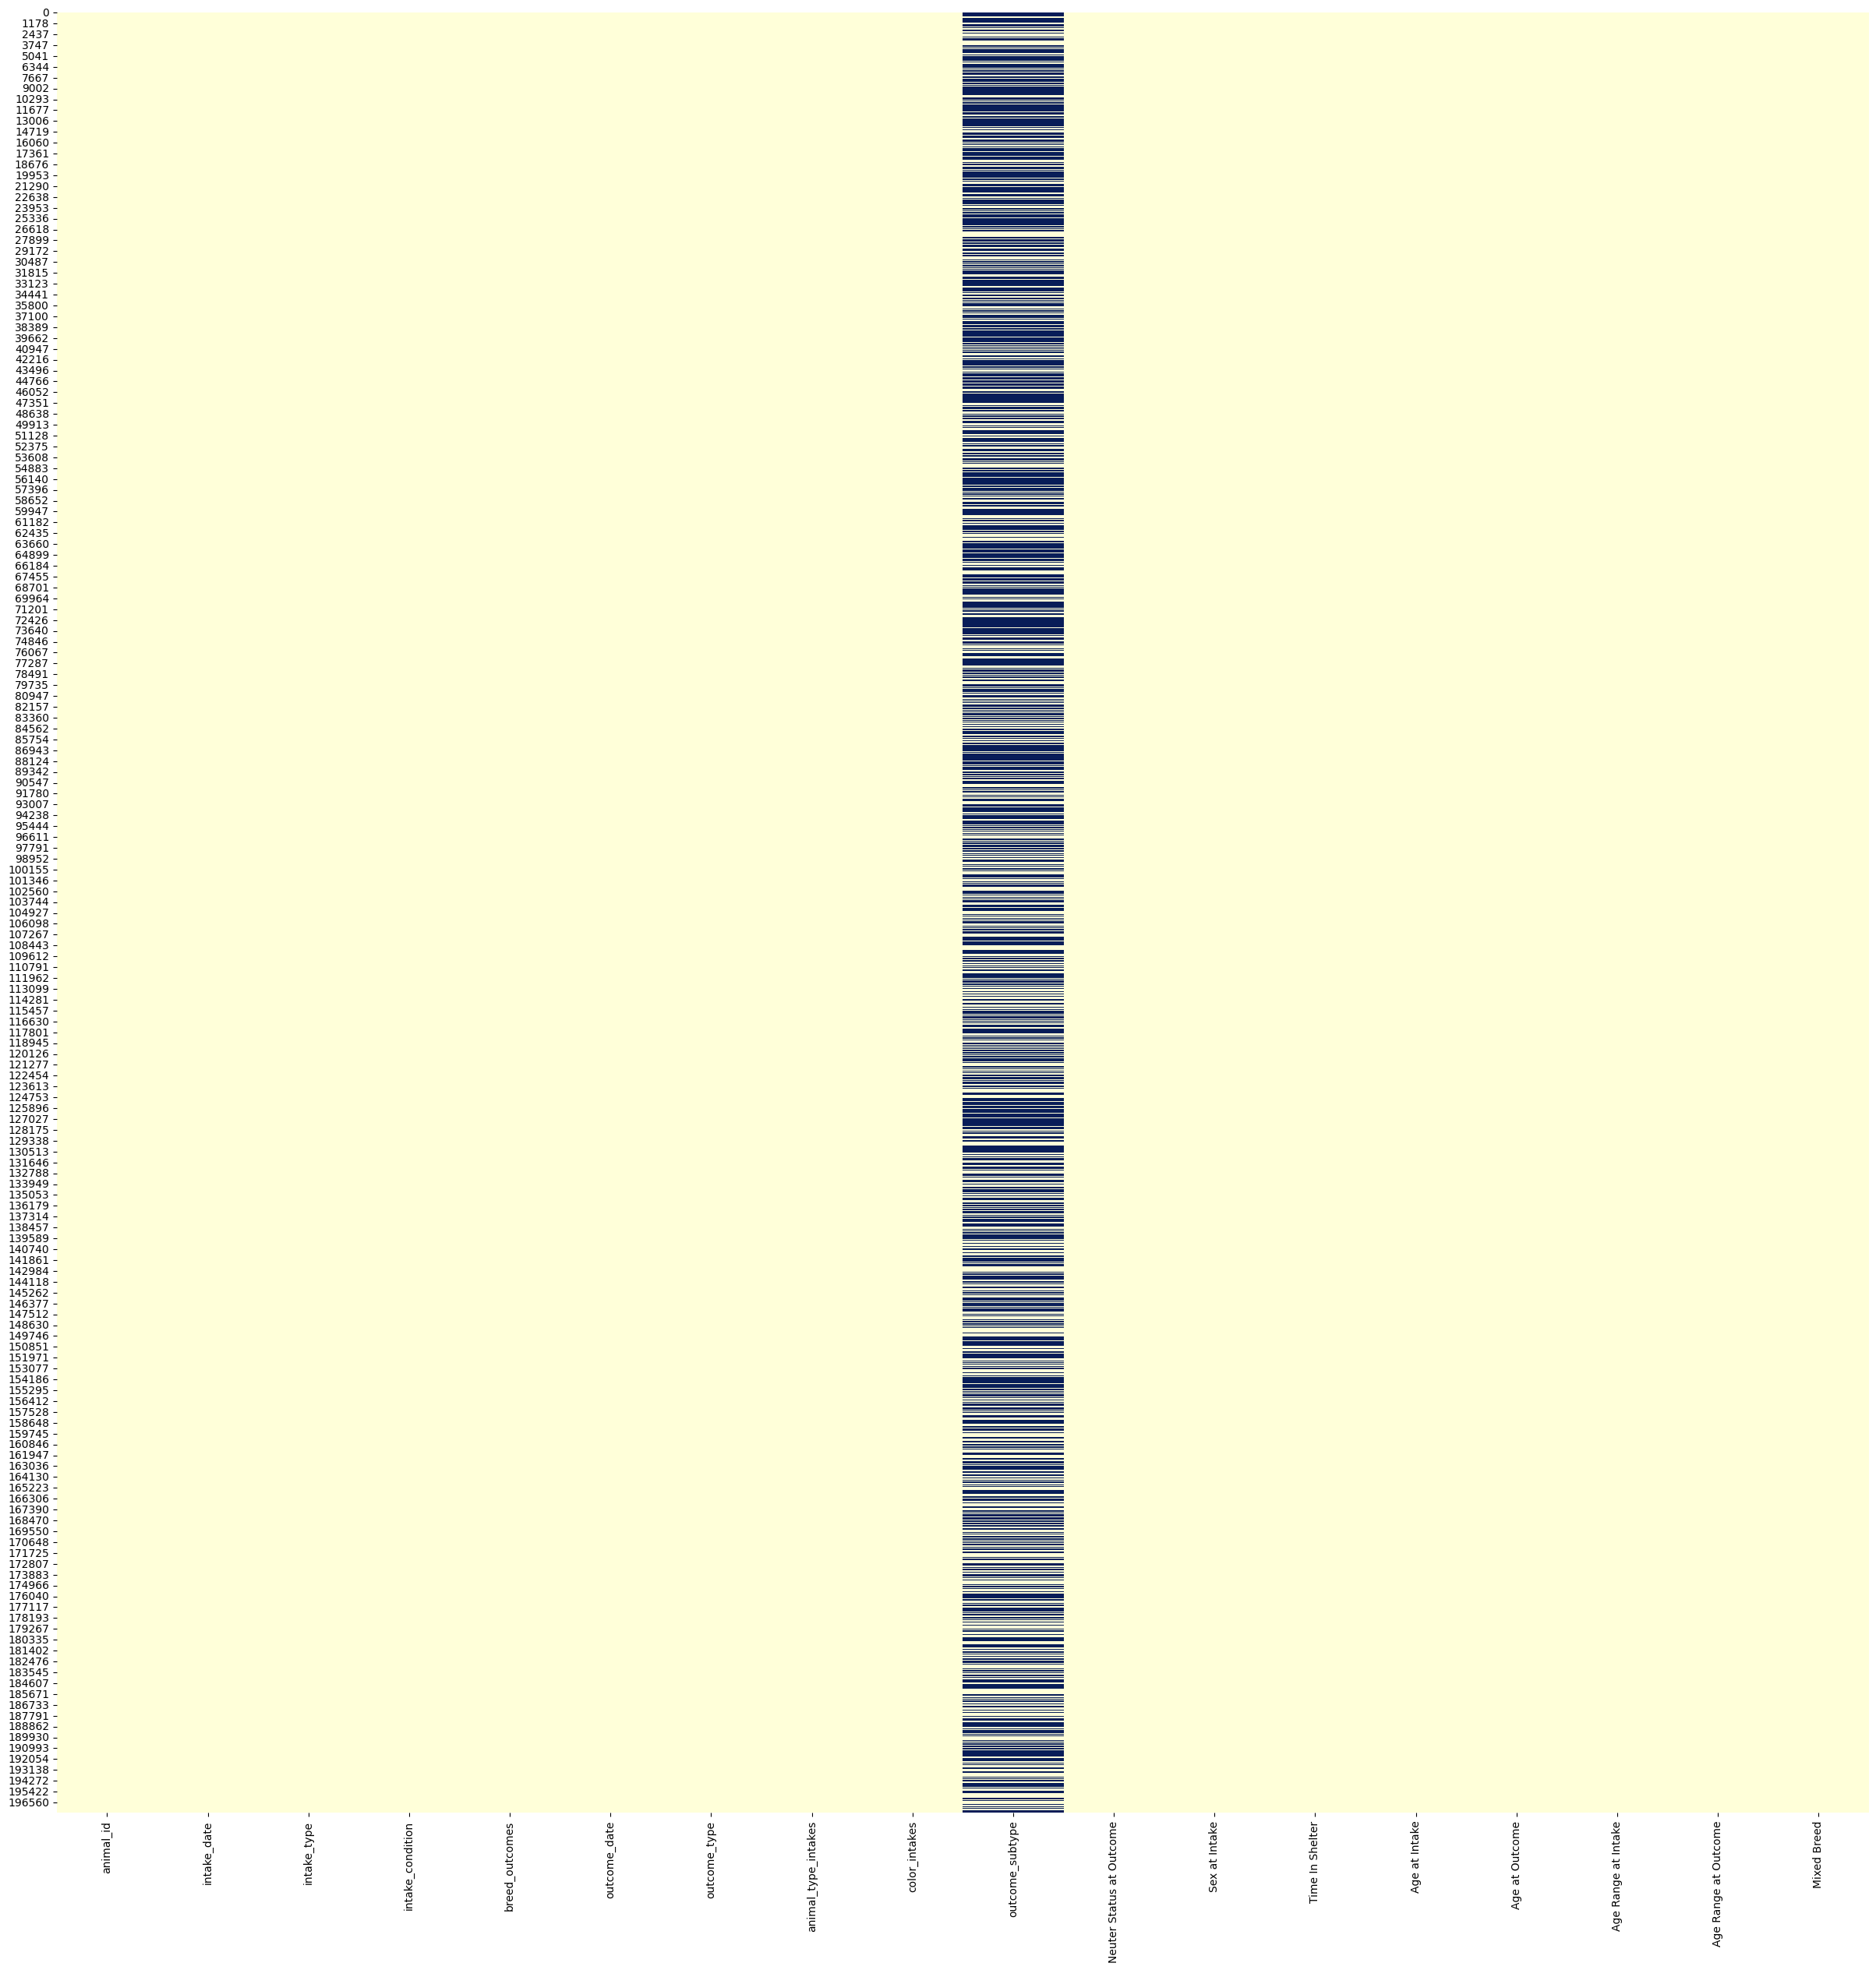

In [52]:
# generate a heatmap of missing values using matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(30,30))
sns.heatmap(shelter_df.isnull(), cbar=False, cmap="YlGnBu")
plt.show()

The heatmap suggests that missing values are concentrated in the outcome_subtype column, but there are also some missing values in the outcome_type column. We look more closely at the numbers of missing values in the two columns using the .isna() and .sum() method.

In [53]:
# check for non-null values
null_val_shelter = shelter_df.isnull().sum()
null_val_shelter

animal_id                       0
intake_date                     0
intake_type                     0
intake_condition                0
breed_outcomes                  0
outcome_date                    0
outcome_type                   36
animal_type_intakes             0
color_intakes                   0
outcome_subtype             97901
Neuter Status at Outcome        0
Sex at Intake                   0
Time In Shelter                 0
Age at Intake                   0
Age at Outcome                  0
Age Range at Intake             0
Age Range at Outcome            0
Mixed Breed                     0
dtype: int64

In [54]:
# checking how many rows have null values in outcome_type columns:
rows_with_nulls = shelter_df[shelter_df['outcome_type'].isnull()].any(axis=1)
null_rows_count = rows_with_nulls.sum()
null_rows_count

36

### 7.2 Addressing null outcome_type values

outcome_type is a very important column for our analysis, and for this reason, we choose to delete the 36 rows that have null values in this column.

In [58]:
# delete the rows that have missing values for outcome_type
shelter_df.dropna(subset=['outcome_type'], inplace=True)

### 7.3 Addressing null outcome_subtype values

We explore the outcome_subtype data to determine its relevance and usefulness to our analysis. First we replace all null values with "Not specified", then we aggregate the data to see what we can learn.

In [59]:
# replace null values for outcome_subtype with "Not specified"
shelter_df["outcome_subtype"] = shelter_df["outcome_subtype"].fillna("Not specified")

In [57]:
# aggregate the data
shelter_df.groupby(["outcome_type", "outcome_subtype"])["outcome_subtype"].count()

outcome_type     outcome_subtype    
Adoption         Barn                       3
                 Foster                 16094
                 Not specified          65366
                 Offsite                  534
Died             At Vet                    98
                 Emergency                 16
                 Enroute                   94
                 In Foster                340
                 In Kennel                747
                 In Surgery                31
                 Not specified            115
Disposal         Not specified            696
                 Rabies Risk               22
Euthanasia       Aggressive               774
                 At Vet                   204
                 Behavior                 188
                 Court/Investigation       97
                 Medical                  349
                 Not specified            269
                 Rabies Risk             4414
                 Suffering               38

We generated a bar chart to illustrate the outcome subtype for those animals who were adopted. 

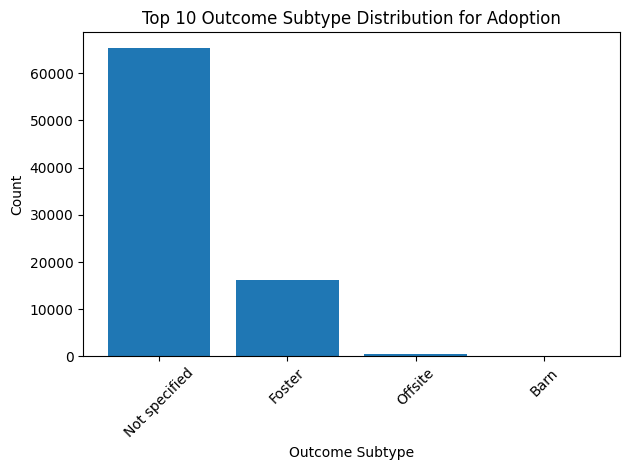

In [60]:
# Filter the df to select only 'Adoption' outcomes:
adoption_df = shelter_df[shelter_df['outcome_type'] == 'Adoption']

# Count the occurrences of each outcome_subtype for Euthanasia cases
outcome_subtype_counts = adoption_df['outcome_subtype'].value_counts()

# Choose the top N most common outcome_subtype values to display
top_n = 10
top_n_values = outcome_subtype_counts.head(top_n)

# Create a bar chart
plt.bar(top_n_values.index, top_n_values.values)
plt.xlabel('Outcome Subtype')
plt.ylabel('Count')
plt.title('Top ' + str(top_n) + ' Outcome Subtype Distribution for Adoption')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

Because the majority of adoption subtypes are "Not specified" we decided that this information is not helpful to our analysis. For this reason, we chose to delete outcome_subtype from our dataset.

In [61]:
# delete outcome_subtype which is not useful for our analysis
shelter_df.drop(['outcome_subtype'],
                axis='columns',
                inplace=True)

shelter_df

,animal_id,intake_date,intake_type,intake_condition,breed_outcomes,outcome_date,outcome_type,animal_type_intakes,color_intakes,Neuter Status at Outcome,Sex at Intake,Time In Shelter,Age at Intake,Age at Outcome,Age Range at Intake,Age Range at Outcome,Mixed Breed
0,665644,2013-10-21 07:59:00,Stray,Sick,Domestic Shorthair Mix,2013-10-21 11:39:00,Transfer,Cat,Calico,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00,0-3 mon,0-3 mon,True
1,665739,2013-10-22 11:11:00,Stray,Normal,Domestic Medium Hair Mix,2013-12-20 17:36:00,Adoption,Cat,Black,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00,0-3 mon,3-6 mon,True
2,665763,2013-10-22 15:10:00,Stray,Normal,Cairn Terrier Mix,2013-10-26 18:32:00,Adoption,Dog,Tan/White,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00,3-6 mon,3-6 mon,True
3,379998,2013-10-23 11:42:00,Stray,Normal,Pit Bull,2013-10-25 12:53:00,Return to Owner,Dog,Black,Intact,Male,2 days 01:11:00,3897 days 11:42:00,3899 days 12:53:00,10-13 yrs,10-13 yrs,False
4,634503,2013-10-01 14:49:00,Owner Surrender,Normal,Norfolk Terrier Mix,2013-10-02 12:40:00,Adoption,Dog,Tan,Spayed,Female,0 days 21:51:00,782 days 14:49:00,783 days 12:40:00,2-3 yrs,2-3 yrs,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197610,886572,2023-08-08 08:29:00,Stray,Neonatal,Domestic Shorthair,2023-08-08 19:17:00,Transfer,Cat,Brown Tabby,Intact,Female,0 days 10:48:00,19 days 08:29:00,19 days 19:17:00,0-3 mon,0-3 mon,False
197611,884257,2023-06-30 13:27:00,Stray,Normal,Domestic Shorthair,2023-08-08 18:10:00,Adoption,Cat,Black/White,Neutered,Male,39 days 04:43:00,61 days 13:27:00,100 days 18:10:00,0-3 mon,3-6 mon,False
197612,886574,2023-08-08 08:29:00,Stray,Neonatal,Domestic Shorthair,2023-08-08 19:18:00,Transfer,Cat,Brown Tabby,Intact,Male,0 days 10:49:00,19 days 08:29:00,19 days 19:18:00,0-3 mon,0-3 mon,False
197613,886649,2023-08-08 18:52:00,Stray,Normal,Domestic Shorthair,2023-08-09 12:49:00,Transfer,Cat,Brown Tabby,Intact,Female,0 days 17:57:00,15 days 18:52:00,16 days 12:49:00,0-3 mon,0-3 mon,False


## 8.0 Some final cleaning steps for readability and ease of use

### 8.1 Changing column names

In [62]:
# lets quickly check what column names our dataframe currently has:
column_names = shelter_df.columns

for column_name in column_names:
    print(column_name)

animal_id
intake_date
intake_type
intake_condition
breed_outcomes
outcome_date
outcome_type
animal_type_intakes
color_intakes
Neuter Status at Outcome
Sex at Intake
Time In Shelter
Age at Intake
Age at Outcome
Age Range at Intake
Age Range at Outcome
Mixed Breed


To improve readability of the data, we rename the columns.

In [63]:
# change column names to improve readability
shelter_df.rename(columns={'animal_id':'Animal ID',
                           'intake_date': 'Intake Date',
                           'found_location': 'Found Location',
                           'intake_type': 'Intake Type',
                           'intake_condition': 'Intake Condition',
                           'breed_outcomes':'Breed',
                           'outcome_date': 'Outcome Date',
                           'outcome_type': 'Outcome Type',
                           'animal_type_intakes': 'Animal',
                           'color_intakes': 'Colour',
                           'Sex at Intake': 'Sex'},
                  inplace=True)

shelter_df.head(3)

,Animal ID,Intake Date,Intake Type,Intake Condition,Breed,Outcome Date,Outcome Type,Animal,Colour,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome,Age Range at Intake,Age Range at Outcome,Mixed Breed
0,665644,2013-10-21 07:59:00,Stray,Sick,Domestic Shorthair Mix,2013-10-21 11:39:00,Transfer,Cat,Calico,Intact,Female,0 days 03:40:00,30 days 07:59:00,30 days 11:39:00,0-3 mon,0-3 mon,True
1,665739,2013-10-22 11:11:00,Stray,Normal,Domestic Medium Hair Mix,2013-12-20 17:36:00,Adoption,Cat,Black,Spayed,Female,59 days 06:25:00,36 days 11:11:00,95 days 17:36:00,0-3 mon,3-6 mon,True
2,665763,2013-10-22 15:10:00,Stray,Normal,Cairn Terrier Mix,2013-10-26 18:32:00,Adoption,Dog,Tan/White,Neutered,Male,4 days 03:22:00,122 days 15:10:00,126 days 18:32:00,3-6 mon,3-6 mon,True


### 8.2 Sorting rows

We sort the rows based on the intake date and reset the index as the old index is not needed.

In [64]:
# sort by Intake Date
shelter_df.sort_values('Intake Date', inplace=True)

# reset index
shelter_df.reset_index(drop=True, inplace=True)

shelter_df.head(5)

,Animal ID,Intake Date,Intake Type,Intake Condition,Breed,Outcome Date,Outcome Type,Animal,Colour,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome,Age Range at Intake,Age Range at Outcome,Mixed Breed
0,521520,2013-10-01 07:51:00,Stray,Normal,Border Terrier/Border Collie,2013-10-01 15:39:00,Return to Owner,Dog,White/Tan,Spayed,Female,0 days 07:48:00,2581 days 07:51:00,2581 days 15:39:00,7-10 yrs,7-10 yrs,False
1,664236,2013-10-01 08:33:00,Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,Transfer,Cat,Orange/White,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00,0-3 mon,0-3 mon,True
2,664237,2013-10-01 08:33:00,Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,Transfer,Cat,Orange/White,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00,0-3 mon,0-3 mon,True
3,664235,2013-10-01 08:33:00,Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:39:00,Transfer,Cat,Orange/White,Unknown,Unknown,0 days 02:06:00,7 days 08:33:00,7 days 10:39:00,0-3 mon,0-3 mon,True
4,664233,2013-10-01 08:53:00,Stray,Injured,Pit Bull Mix,2013-10-01 15:33:00,Euthanasia,Dog,Blue/White,Intact,Female,0 days 06:40:00,1097 days 08:53:00,1097 days 15:33:00,3-5 yrs,3-5 yrs,True


#### 8.2.1 Addressing an observation: potential duplicates in data

When looking at the data above, we noticed rows 1-3 are identical except for animal id. We then used the below code to check if there were any more rows in the data like this and saw that there were around 3000 potential duplicates.

When looking further into this, we noticed that the majority had a very young Intake Age. We thought that this is likely to mean that the animals were brought to the shelter as a litter. Therefore we chose not remove these rows from our data.

In [65]:
shelter_df[shelter_df.duplicated(subset=shelter_df.columns.difference(['Animal ID']))]

,Animal ID,Intake Date,Intake Type,Intake Condition,Breed,Outcome Date,Outcome Type,Animal,Colour,Neuter Status at Outcome,Sex,Time In Shelter,Age at Intake,Age at Outcome,Age Range at Intake,Age Range at Outcome,Mixed Breed
2,664237,2013-10-01 08:33:00,Stray,Normal,Domestic Shorthair Mix,2013-10-01 10:44:00,Transfer,Cat,Orange/White,Unknown,Unknown,0 days 02:11:00,7 days 08:33:00,7 days 10:44:00,0-3 mon,0-3 mon,True
212,664503,2013-10-04 12:08:00,Stray,Normal,Domestic Shorthair Mix,2013-10-10 18:17:00,Adoption,Cat,Black/White,Neutered,Male,6 days 06:09:00,76 days 12:08:00,82 days 18:17:00,0-3 mon,0-3 mon,True
268,664371,2013-10-05 13:13:00,Public Assist,Normal,Labrador Retriever/German Shepherd,2013-10-12 18:00:00,Return to Owner,Dog,Black,Neutered,Male,7 days 04:47:00,131 days 13:13:00,138 days 18:00:00,3-6 mon,3-6 mon,False
615,664958,2013-10-11 15:21:00,Stray,Normal,Labrador Retriever Mix,2013-10-14 17:06:00,Transfer,Dog,Black/White,Intact,Female,3 days 01:45:00,61 days 15:21:00,64 days 17:06:00,0-3 mon,0-3 mon,True
693,665043,2013-10-12 18:39:00,Stray,Normal,Domestic Shorthair Mix,2013-10-12 19:24:00,Transfer,Cat,Orange Tabby,Intact,Male,0 days 00:45:00,22 days 18:39:00,22 days 19:24:00,0-3 mon,0-3 mon,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172861,886787,2023-08-10 08:00:00,Stray,Normal,Pit Bull,2023-08-10 16:57:00,Transfer,Dog,White,Unknown,Unknown,0 days 08:57:00,1 days 08:00:00,1 days 16:57:00,0-3 mon,0-3 mon,False
172862,886788,2023-08-10 08:00:00,Stray,Normal,Pit Bull,2023-08-10 16:57:00,Transfer,Dog,White,Unknown,Unknown,0 days 08:57:00,1 days 08:00:00,1 days 16:57:00,0-3 mon,0-3 mon,False
172863,886738,2023-08-10 08:00:00,Stray,Normal,Pit Bull,2023-08-10 16:57:00,Transfer,Dog,White,Unknown,Unknown,0 days 08:57:00,1 days 08:00:00,1 days 16:57:00,0-3 mon,0-3 mon,False
172864,886732,2023-08-10 08:00:00,Stray,Normal,Pit Bull,2023-08-10 16:56:00,Transfer,Dog,White,Unknown,Unknown,0 days 08:56:00,1 days 08:00:00,1 days 16:56:00,0-3 mon,0-3 mon,False


### 8.3 Rearranging column postions

We rearrange the column positions for easier readability of the data.

In [66]:
shelter_df = shelter_df.reindex(columns=['Animal ID',
                                         'Animal',
                                         'Intake Date',
                                         'Outcome Date',
                                         'Time In Shelter',
                                         'Age at Intake',
                                         'Age Range at Intake',
                                         'Age at Outcome',
                                         'Age Range at Outcome',
                                         'Intake Condition',
                                         'Intake Type',
                                         'Outcome Type',
                                         'Sex',
                                         'Neuter Status at Outcome',
                                         'Breed',
                                         'Mixed Breed',
                                         'Colour'])

shelter_df

,Animal ID,Animal,Intake Date,Outcome Date,Time In Shelter,Age at Intake,Age Range at Intake,Age at Outcome,Age Range at Outcome,Intake Condition,Intake Type,Outcome Type,Sex,Neuter Status at Outcome,Breed,Mixed Breed,Colour
0,521520,Dog,2013-10-01 07:51:00,2013-10-01 15:39:00,0 days 07:48:00,2581 days 07:51:00,7-10 yrs,2581 days 15:39:00,7-10 yrs,Normal,Stray,Return to Owner,Female,Spayed,Border Terrier/Border Collie,False,White/Tan
1,664236,Cat,2013-10-01 08:33:00,2013-10-01 10:44:00,0 days 02:11:00,7 days 08:33:00,0-3 mon,7 days 10:44:00,0-3 mon,Normal,Stray,Transfer,Unknown,Unknown,Domestic Shorthair Mix,True,Orange/White
2,664237,Cat,2013-10-01 08:33:00,2013-10-01 10:44:00,0 days 02:11:00,7 days 08:33:00,0-3 mon,7 days 10:44:00,0-3 mon,Normal,Stray,Transfer,Unknown,Unknown,Domestic Shorthair Mix,True,Orange/White
3,664235,Cat,2013-10-01 08:33:00,2013-10-01 10:39:00,0 days 02:06:00,7 days 08:33:00,0-3 mon,7 days 10:39:00,0-3 mon,Normal,Stray,Transfer,Unknown,Unknown,Domestic Shorthair Mix,True,Orange/White
4,664233,Dog,2013-10-01 08:53:00,2013-10-01 15:33:00,0 days 06:40:00,1097 days 08:53:00,3-5 yrs,1097 days 15:33:00,3-5 yrs,Injured,Stray,Euthanasia,Female,Intact,Pit Bull Mix,True,Blue/White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172872,886851,Dog,2023-08-11 15:38:00,2023-08-11 18:59:00,0 days 03:21:00,2556 days 15:38:00,5-7 yrs,2556 days 18:59:00,5-7 yrs,Normal,Stray,Return to Owner,Male,Intact,Pit Bull,False,Gray
172873,886875,Other,2023-08-11 20:12:00,2023-08-12 11:10:00,0 days 14:58:00,730 days 20:12:00,2-3 yrs,731 days 11:10:00,2-3 yrs,Normal,Wildlife,Euthanasia,Unknown,Unknown,Bat,False,Brown/Black
172874,886874,Other,2023-08-11 20:12:00,2023-08-12 11:08:00,0 days 14:56:00,730 days 20:12:00,2-3 yrs,731 days 11:08:00,2-3 yrs,Normal,Wildlife,Euthanasia,Unknown,Unknown,Bat,False,Brown/Black
172875,886877,Other,2023-08-11 20:50:00,2023-08-12 11:08:00,0 days 14:18:00,730 days 20:50:00,2-3 yrs,731 days 11:08:00,2-3 yrs,Normal,Wildlife,Euthanasia,Unknown,Unknown,Bat,False,Brown


## 9.0 Write cleaned data to csv file

In [67]:
# write cleaned data to csv
shelter_df.to_csv('Austin_Animal_Center_clean_data.csv')

## 10.0 Descriptive Analysis

### Column Datatypes
It is important to determine what datatypes you are working with before starting the analysis

In [68]:
# finding out datatypes of columns:
shelter_df['Intake Date'] = pd.to_datetime(shelter_df['Intake Date'])
shelter_df['Outcome Date'] = pd.to_datetime(shelter_df['Outcome Date'])
shelter_df[['Time In Shelter', 'Age at Intake', 'Age at Outcome']] = shelter_df[['Time In Shelter', 'Age at Intake', 'Age at Outcome']].apply(pd.to_timedelta)
shelter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172877 entries, 0 to 172876
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   Animal ID                 172877 non-null  int32          
 1   Animal                    172877 non-null  object         
 2   Intake Date               172877 non-null  datetime64[ns] 
 3   Outcome Date              172877 non-null  datetime64[ns] 
 4   Time In Shelter           172877 non-null  timedelta64[ns]
 5   Age at Intake             172877 non-null  timedelta64[ns]
 6   Age Range at Intake       172877 non-null  category       
 7   Age at Outcome            172877 non-null  timedelta64[ns]
 8   Age Range at Outcome      172877 non-null  category       
 9   Intake Condition          172877 non-null  object         
 10  Intake Type               172877 non-null  object         
 11  Outcome Type              172877 non-null  object   

### 10.6. Calculating the median age of animals (by type, most common ones) entering and leaving the shelter. Grouping animals by age (puppies, adult, senior) and analysing which age group has:\(1) the highest adoption rates\(2) the longest / shortest time in shelter\(3) the highest number of intakes

#### *Calculating median age of animals by type at entering the shelter:*

In [69]:
# calculating median age of animals by type at entering the shelter:

median_intake_age_by_type = shelter_df.groupby(['Animal'])['Age at Intake'].median()

median_intake_age_by_type

Animal
Bird    365 days 16:57:00
Cat      84 days 15:00:00
Dog     729 days 19:11:00
Other   365 days 19:04:00
Name: Age at Intake, dtype: timedelta64[ns]

#### *Creating a bar plot to visualise Age Range of animals at Intake who were Adopted:*

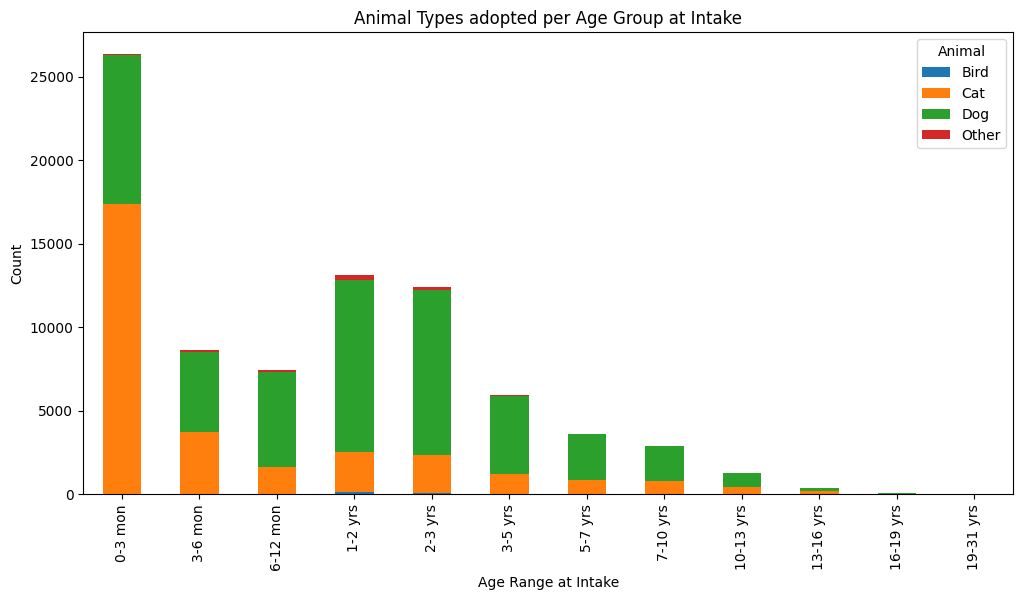

<Figure size 1200x600 with 0 Axes>

In [71]:
# ensuring 'Age Range at Intake' column is string type:
shelter_df['Animal', 'Age Range at Intake'] = shelter_df['Age Range at Intake'].astype(str)

# Filtering data for adoption:
adoptionData = shelter_df[shelter_df['Outcome Type'] == 'Adoption']

# Grouping and counting data by Age Range at Intake and Animal type:
ageAnimalAdoptIntCounts = adoptionData.groupby(['Age Range at Intake', 'Animal']).size().unstack()

# plotting a bar chart to show Animal Types adopted per Age Group:
ax = ageAnimalAdoptIntCounts.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.figure(figsize = (12, 6))
ax.set(xlabel = 'Age Range at Intake')
ax.set(ylabel = 'Count')
ax.set(title = 'Animal Types adopted per Age Group at Intake')

plt.tight_layout()
plt.show()

#### *Calculating median age of animals by type when leaving the shelter:*

In [73]:
# calculating median age of animals by type when leaving the shelter:

median_outcome_age_by_type = shelter_df.groupby(['Animal'])['Age at Outcome'].median()

median_outcome_age_by_type

Animal
Bird    381 days 16:30:00
Cat     120 days 15:14:00
Dog     734 days 16:05:00
Other   367 days 08:47:00
Name: Age at Outcome, dtype: timedelta64[ns]

#### *Creating a bar plot to visualise Age Range of animals at Outcome who were Adopted:*

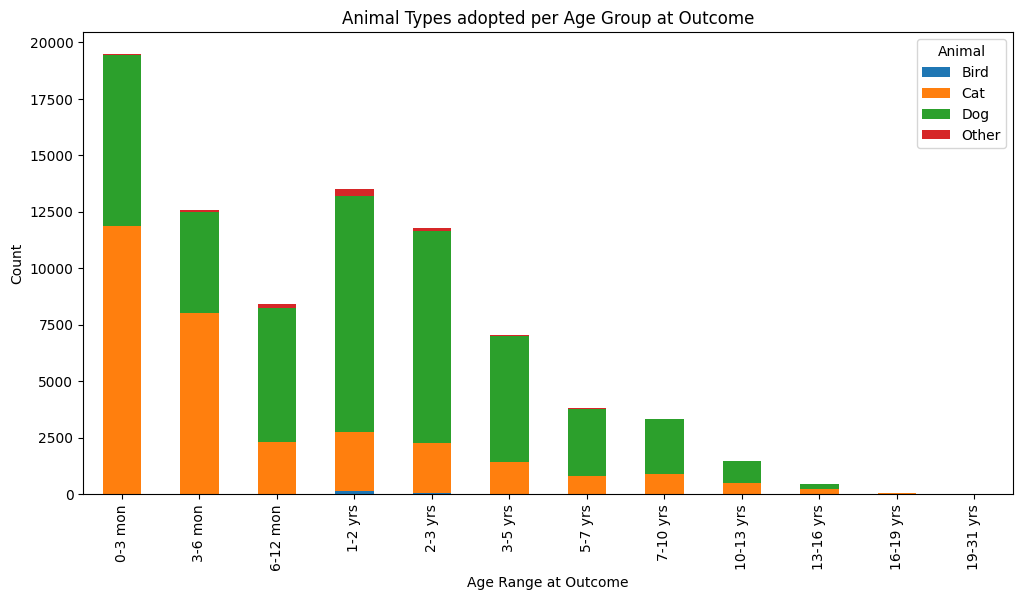

<Figure size 1200x600 with 0 Axes>

In [72]:
# ensuring 'Age Range at Outcome' column is string type:
shelter_df['Animal', 'Age Range at Outcome'] = shelter_df['Age Range at Outcome'].astype(str)

# Filtering data for adoption:
adoptionData = shelter_df[shelter_df['Outcome Type'] == 'Adoption']

# Grouping and counting data by Age Range at Intake and Animal type:
ageAnimalAdoptOutCounts = adoptionData.groupby(['Age Range at Outcome', 'Animal']).size().unstack()

# plotting a bar chart to show Animal Types adopted per Age Group:
ax = ageAnimalAdoptOutCounts.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.figure(figsize = (12, 6))
ax.set(xlabel = 'Age Range at Outcome')
ax.set(ylabel = 'Count')
ax.set(title = 'Animal Types adopted per Age Group at Outcome')

plt.tight_layout()
plt.show()

#### *Creating a scatter plot to visualise Age Range of animals at Intake vs Time in Shelter:*

In [74]:
# converting Time in Shelter (timedelta data type) to numeric (days):
shelter_df['Time In Shelter'] = shelter_df['Time In Shelter'].dt.days

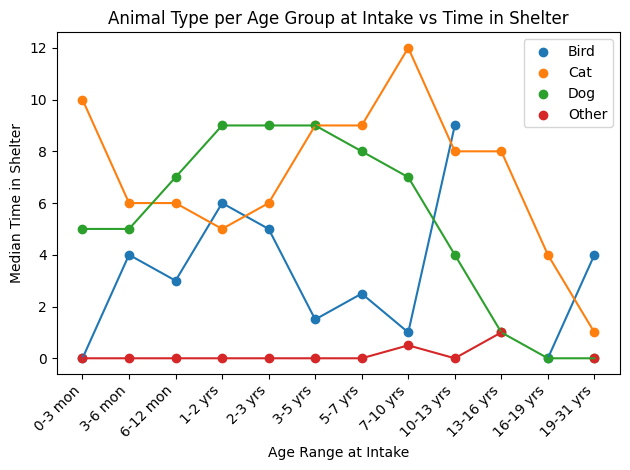

In [134]:
# ensuring 'Age Range at Intake' column is string type:
shelter_df['Animal', 'Age Range at Intake'] = shelter_df['Age Range at Intake'].astype(str)

# Grouping data and calculating median Time in Shelter by 'Age Range at Intake' and 'Animal'
ageAnimalTimeIntMedian = shelter_df.groupby(['Age Range at Intake', 'Animal'])['Time In Shelter'].median().unstack()

# Creating a scatter plot:
for Animal in ageAnimalTimeIntMedian.columns:
    plt.scatter(ageAnimalTimeIntMedian.index, ageAnimalTimeIntMedian[Animal], label = Animal)
    plt.plot(ageAnimalTimeIntMedian.index, ageAnimalTimeIntMedian[Animal])

# plotting a scatter plot to show Animal Type per Age Group at Intake vs Time in Shelter:
plt.xlabel('Age Range at Intake')
plt.ylabel('Median Time in Shelter')
plt.title('Animal Type per Age Group at Intake vs Time in Shelter')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()

plt.tight_layout()
plt.show()

#### *Creating a scatter plot to visualise Age Range of animals at Outcome vs Time in Shelter:*

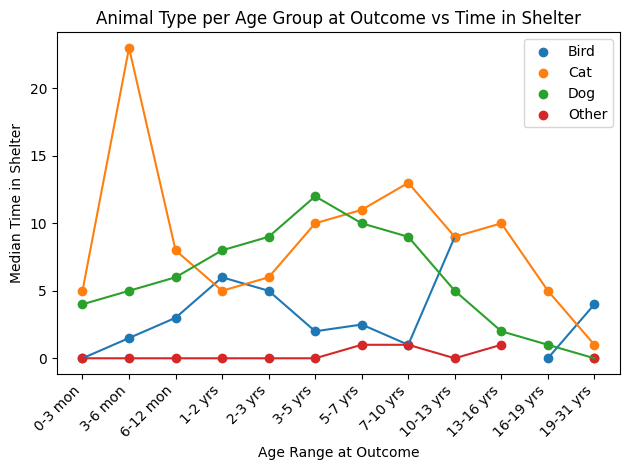

In [135]:
# ensuring 'Age Range at Outcome' column is string type:
shelter_df['Animal', 'Age Range at Outcome'] = shelter_df['Age Range at Outcome'].astype(str)

# Grouping data and calculating median Time in Shelter by 'Age Range at Outcome' and 'Animal'
ageAnimalTimeOutMedian = shelter_df.groupby(['Age Range at Outcome', 'Animal'])['Time In Shelter'].median().unstack()

# Creating a scatter plot:
for Animal in ageAnimalTimeOutMedian.columns:
    plt.scatter(ageAnimalTimeOutMedian.index, ageAnimalTimeOutMedian[Animal], label = Animal)
    plt.plot(ageAnimalTimeOutMedian.index, ageAnimalTimeOutMedian[Animal])

# plotting a scatter plot to show Animal Type per Age Group at Outcome vs Time in Shelter:
plt.xlabel('Age Range at Outcome')
plt.ylabel('Median Time in Shelter')
plt.title('Animal Type per Age Group at Outcome vs Time in Shelter')
plt.xticks(rotation = 45, ha = 'right')
plt.legend()

plt.tight_layout()
plt.show()

*The animals do not seem to spend much time in the shelter at a senior age which is to expected. The peak stay in the shelter appears to be at a junior age and the infants do not spend as much time in the shelter.*

#### *Creating a bar plot to visualise Age Range of animals at Intake vs Number of Intakes:*

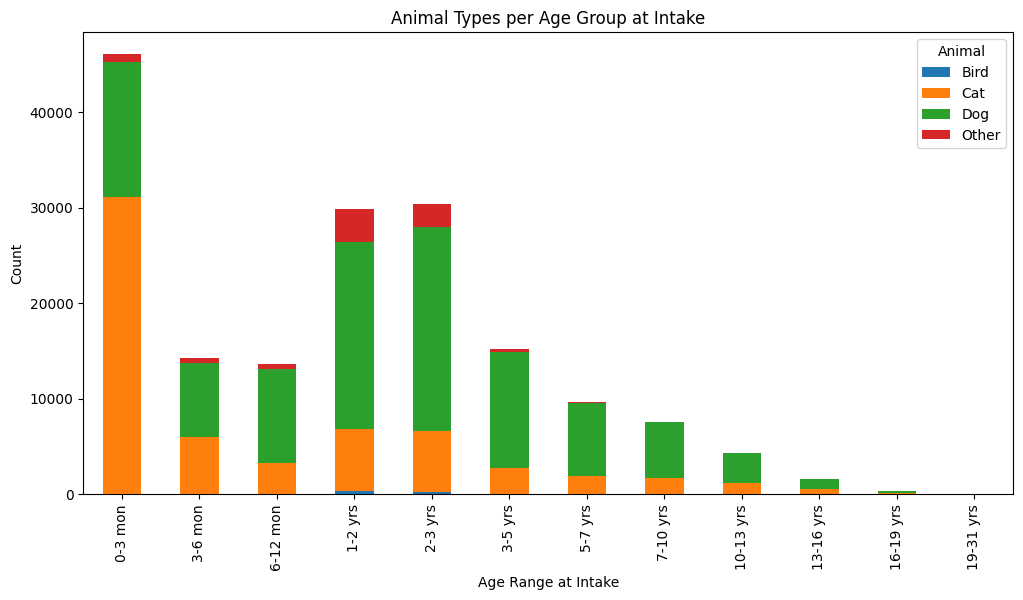

<Figure size 1200x600 with 0 Axes>

In [77]:
# ensuring 'Age Range at Intake' column is string type:
shelter_df['Animal', 'Age Range at Intake'] = shelter_df['Age Range at Intake'].astype(str)

# Grouping and counting data by Age Range at Intake and Animal type:
ageAnimalCounts = shelter_df.groupby(['Age Range at Intake', 'Animal']).size().unstack()

# plotting a bar chart to show Animal Types adopted per Age Group:
ax = ageAnimalCounts.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.figure(figsize = (12, 6))
ax.set(xlabel = 'Age Range at Intake')
ax.set(ylabel = 'Count')
ax.set(title = 'Animal Types per Age Group at Intake')
ax.legend(title = 'Animal')

plt.tight_layout()
plt.show()

*There appears to be an increase in the number of dogs being given shelter between the ages of 1 and 3 yrs old. The numbers of both dogs and cats being given to the shelter tapers with age. Kittens between 0 and 3 months old are the highest age group of cats being given to the shelter.*

### 10.7. Analysing most common animal types entering the shelter with pie/bar charts to visualise results

#### *Calculating the most common type of animal to be given shelter:*

In [78]:
# Calculating the most common type of animal to be given shelter:

shelter_df['Animal'].value_counts()

Animal
Dog      102700
Cat       61332
Other      8093
Bird        752
Name: count, dtype: int64

#### *Creating pie chart to visualise the most common type of animal to be given shelter:*

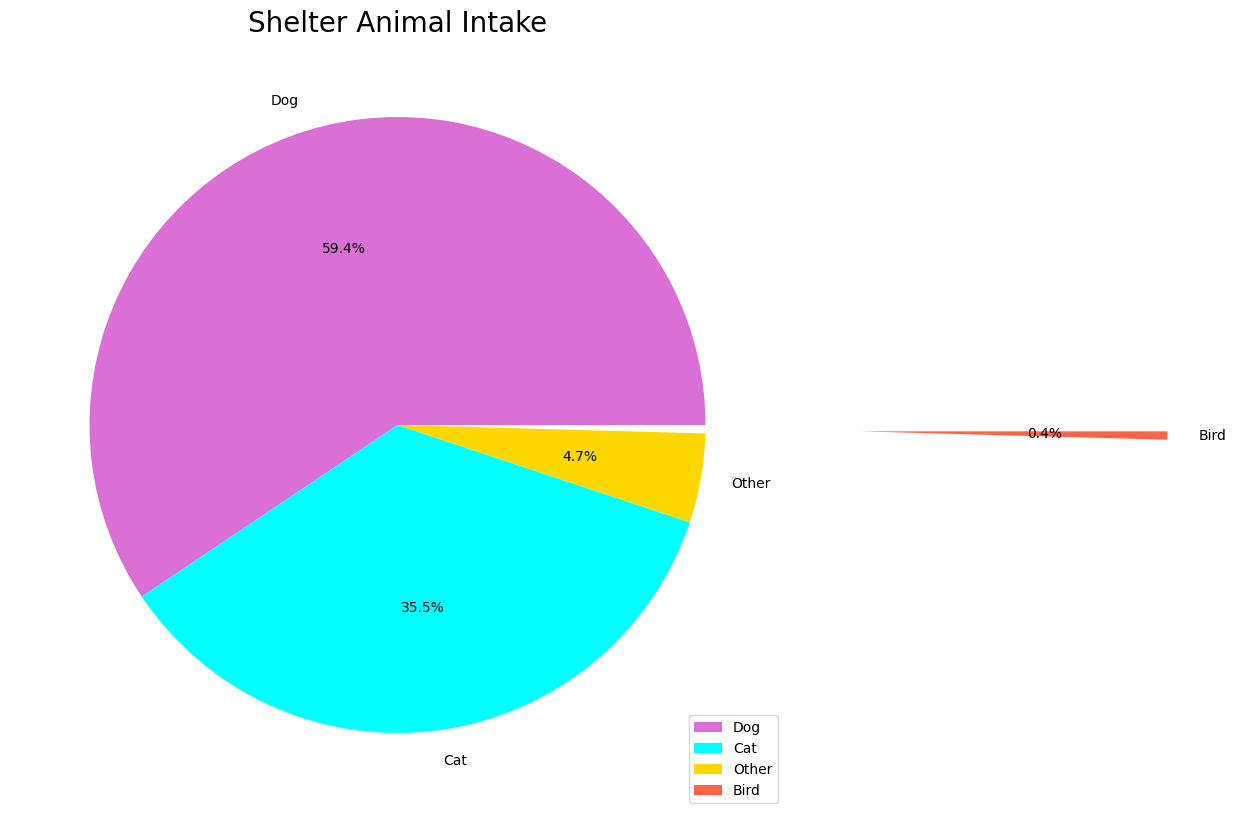

In [85]:
# creating pie chart to visualise result:

numAnimals = shelter_df['Animal'].value_counts().tolist() # putting the values for each animal type into a list
mylabels = ['Dog', 'Cat', 'Other', 'Bird'] # label titles
myexplode = [0, 0, 0, 1.5] #exploding smaller proportions to improve readability
mycolors = ['orchid', 'cyan', 'gold', 'tomato'] # matplotlib colours

plt.axis("equal")
plt.pie(numAnimals, labels = mylabels, explode = myexplode, autopct='%1.1f%%', textprops = {'fontsize': 10}, colors = mycolors)
plt.legend(fontsize = "10", loc='lower right') # reducing legend size for readability
plt.title('Shelter Animal Intake', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(10,10) # setting pie chart size
plt.show()

#### *We can see from results above that dogs and cats are the most common animal types to be given to the shelter so will further investigate the top two common animal types (cats and dogs) according to breed and colour:*

#### *Creating a bar chart to visualise Cat breeds at intake:*

In [86]:
# View all Cat breed:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Breed'].value_counts())

,count
Breed,
Domestic Shorthair Mix,34587
Domestic Shorthair,16016
Domestic Medium Hair Mix,3434
Domestic Longhair Mix,1751
Domestic Medium Hair,1548
...,...
Domestic Longhair/Russian Blue,1
Turkish Angora,1
Snowshoe/Siamese,1


In [87]:
# generate Cat breed row value counts into a variable:
catBreedCount = shelter_df[shelter_df.Animal == 'Cat']['Breed'].value_counts()[:20] #to bring up the first 20 most popular breeds as there are numerous ones
catBreedCount

Breed
Domestic Shorthair Mix      34587
Domestic Shorthair          16016
Domestic Medium Hair Mix     3434
Domestic Longhair Mix        1751
Domestic Medium Hair         1548
Siamese Mix                  1470
Domestic Longhair             601
Siamese                       444
Snowshoe Mix                  229
American Shorthair Mix        226
Maine Coon Mix                129
Manx Mix                      122
Russian Blue Mix              100
Ragdoll Mix                    54
Himalayan Mix                  48
American Shorthair             46
Maine Coon                     37
Russian Blue                   35
Snowshoe                       32
Persian Mix                    22
Name: count, dtype: int64

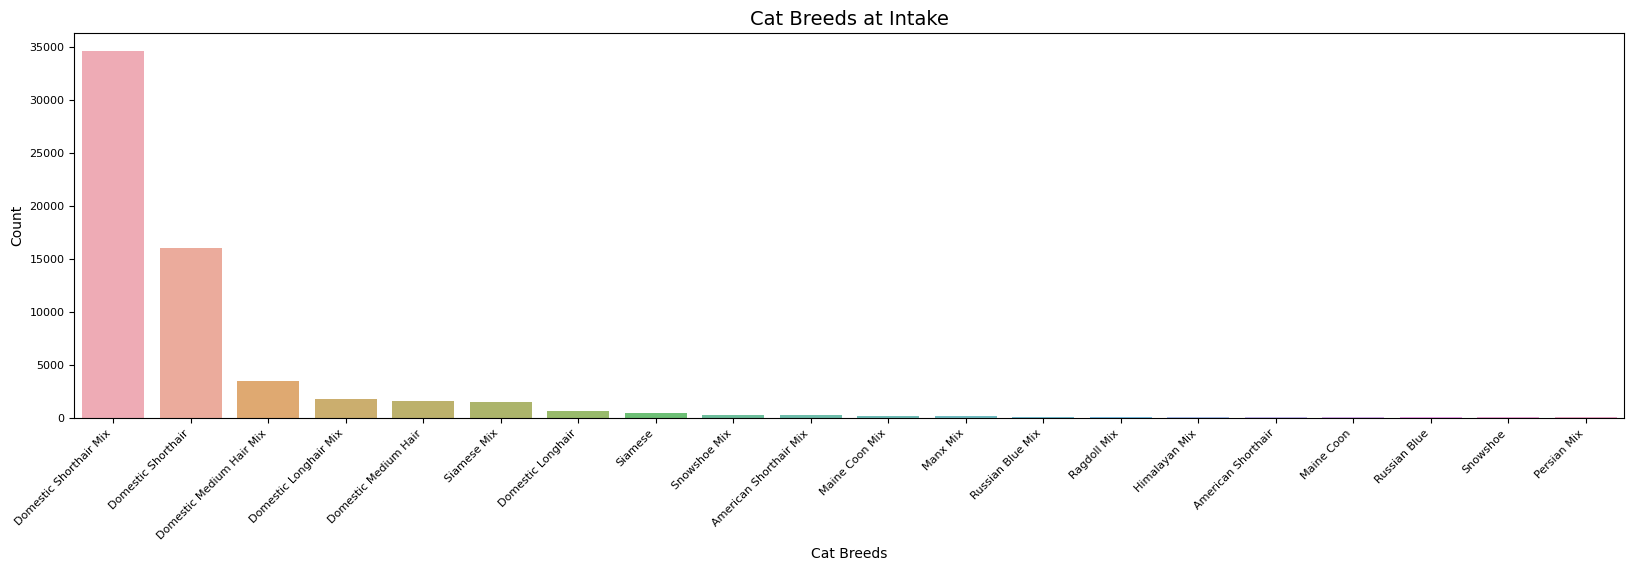

In [88]:
# Creating a bar chart to visualise Cat breeds at intake:

plt.figure(figsize=(20,5))
sns.barplot(x=catBreedCount.index, y=catBreedCount.values, alpha = 0.8)
plt.title('Cat Breeds at Intake', fontsize = 14)
plt.ylabel('Count', fontsize = 10)
plt.xlabel('Cat Breeds', fontsize = 10)
plt.xticks(rotation = 45, ha = 'right', fontsize = 8) # reducing font size of x axis as there are 20 cat breeds to fit on plot
plt.yticks(fontsize = 8)
plt.show()

*Domestic Shorthair Mix and Domestic Shorthair are the most common breeds of cat being given shelter.*

#### *Creating a bar chart to visualise Dog breeds at intake:*

In [89]:
# View all Dog breeds:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Breed'].value_counts())

,count
Breed,
Pit Bull Mix,12644
Labrador Retriever Mix,9729
Chihuahua Shorthair Mix,7445
German Shepherd Mix,4473
Pit Bull,3064
...,...
Collie Rough/Pointer,1
Australian Shepherd/Collie Smooth,1
Whippet/Catahoula,1


In [90]:
# generate Dog breed row value counts into a variable:
dogBreedCount = shelter_df[shelter_df.Animal == 'Dog']['Breed'].value_counts()[:40] #to bring up the first 40 most popular breeds as there are numerous ones
dogBreedCount

Breed
Pit Bull Mix                          12644
Labrador Retriever Mix                 9729
Chihuahua Shorthair Mix                7445
German Shepherd Mix                    4473
Pit Bull                               3064
Australian Cattle Dog Mix              2160
Labrador Retriever                     1784
German Shepherd                        1784
Chihuahua Shorthair                    1748
Boxer Mix                              1412
Border Collie Mix                      1307
Dachshund Mix                          1268
Rat Terrier Mix                        1262
Staffordshire Mix                      1086
Siberian Husky Mix                     1081
Miniature Poodle Mix                   1044
Catahoula Mix                           994
Australian Shepherd Mix                 931
Siberian Husky                          875
Great Pyrenees Mix                      783
Pointer Mix                             777
Beagle Mix                              774
Miniature Schnauzer Mix   

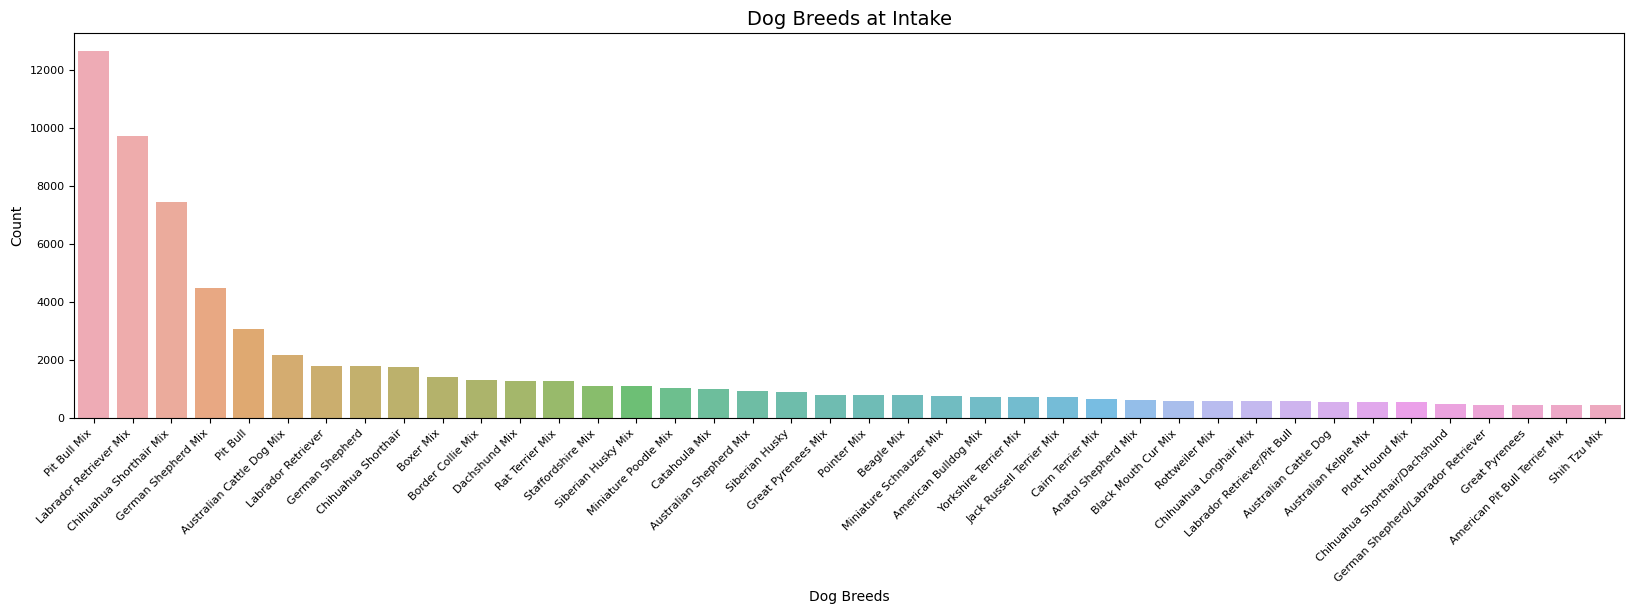

In [91]:
# Creating a bar chart to visualise Dog breeds at intake:

plt.figure(figsize=(20,5))
sns.barplot(x=dogBreedCount.index, y=dogBreedCount.values, alpha = 0.8)
plt.title('Dog Breeds at Intake', fontsize = 14)
plt.ylabel('Count', fontsize = 10)
plt.xlabel('Dog Breeds', fontsize = 10)
plt.xticks(rotation = 45, ha = 'right', fontsize = 8) # reducing font size of x axis as there are 20 cat breeds to fit on plot
plt.yticks(fontsize = 8)
plt.show()

*Pit Bull Mix, Labrador Retriever Mix and Chihuahua Shorthair Mix are the most common breeds of dog being given shelter.*

#### *Creating a bar chart to visualise Cat colours at intake:*

In [92]:
# View all Cat colours:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Colour'].value_counts())

,count
Colour,
Brown Tabby,9282
Black,7972
Black/White,5551
Brown Tabby/White,4872
Orange Tabby,4486
...,...
Blue Smoke/Gray,1
Black/Seal Point,1
Seal Point/Gray,1


In [93]:
# generate Cat colour row value counts into a variable:
catColourCount = shelter_df[shelter_df.Animal == 'Cat']['Colour'].value_counts()[:40] #to bring up the first 40 most popular breeds as there are numerous ones
catColourCount

Colour
Brown Tabby           9282
Black                 7972
Black/White           5551
Brown Tabby/White     4872
Orange Tabby          4486
Tortie                2817
Calico                2705
Blue Tabby            2484
Blue                  2318
Orange Tabby/White    2295
Torbie                1901
Blue/White            1617
Cream Tabby           1140
Blue Tabby/White      1132
White/Black           1069
Lynx Point             858
White/Brown Tabby      648
White                  583
Seal Point             551
Cream Tabby/White      502
Gray Tabby             414
Flame Point            391
White/Blue             387
Torbie/White           381
Black Tabby            263
White/Orange Tabby     224
Black Smoke            208
Gray Tabby/White       203
Orange/White           192
Calico/White           174
Orange                 170
Gray                   166
Tortie Point           164
Lilac Point            163
Gray/White             153
Tortie/White           153
White/Gray           

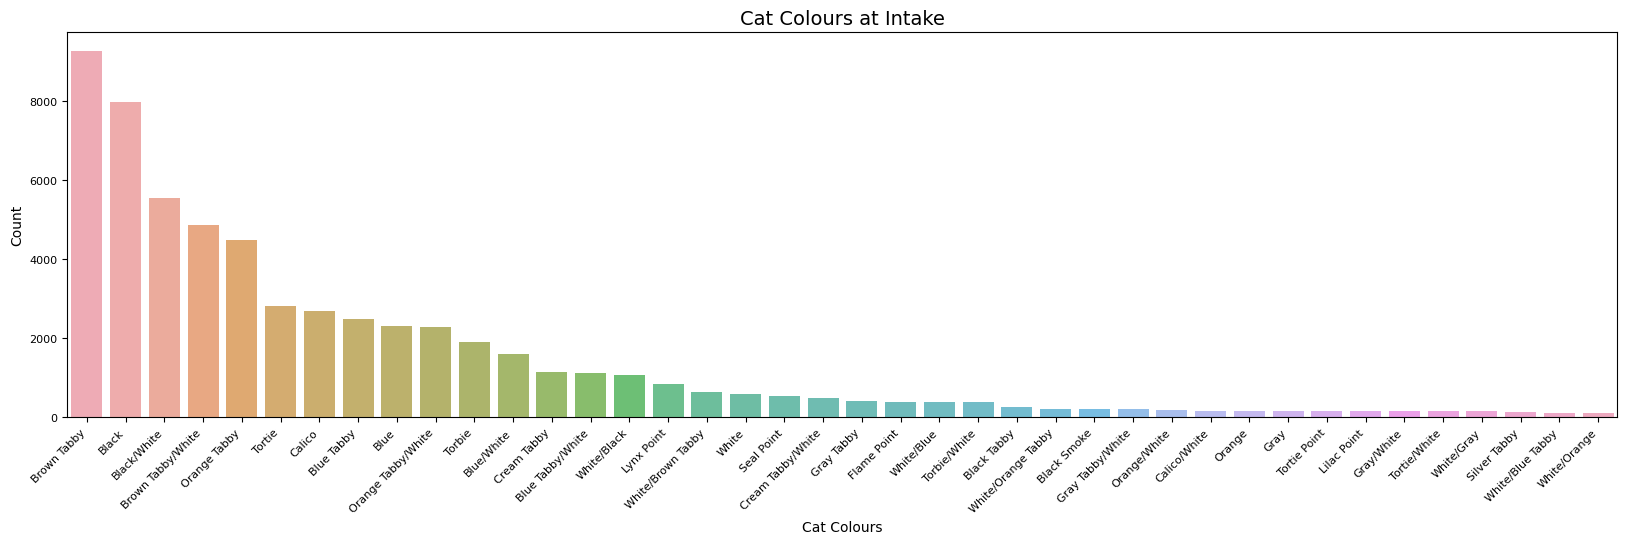

In [94]:
# Creating a bar chart to visualise Cat colours at intake:

plt.figure(figsize=(20,5))
sns.barplot(x=catColourCount.index, y=catColourCount.values, alpha = 0.8)
plt.title('Cat Colours at Intake', fontsize = 14)
plt.ylabel('Count', fontsize = 10)
plt.xlabel('Cat Colours', fontsize = 10)
plt.xticks(rotation = 45, ha = 'right', fontsize = 8) # reducing font size of x axis as there are 20 cat breeds to fit on plot
plt.yticks(fontsize = 8)
plt.show()

*Brown Tabby, Black and Black/ White are the most common colours of cat to be given shelter*

#### *Creating a bar chart to visualise Dog colours at intake:*

In [95]:
# View all Dog colours:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Colour'].value_counts())

,count
Colour,
Black/White,12397
Brown/White,5919
Tan/White,5429
White,5286
Black,5117
...,...
Black Smoke/Blue Tick,1
White/Tortie,1
Black/Gold,1


In [96]:
# generate Dog colour row value counts into a variable:
dogColourCount = shelter_df[shelter_df.Animal == 'Dog']['Colour'].value_counts()[:40] #to bring up the first 40 most popular breeds as there are numerous ones
dogColourCount

Colour
Black/White               12397
Brown/White                5919
Tan/White                  5429
White                      5286
Black                      5117
Tan                        4320
Black/Tan                  3873
Brown                      3852
Tricolor                   3799
White/Black                3703
Black/Brown                3603
Blue/White                 3572
White/Brown                3422
Brown Brindle/White        3303
Brown/Black                2831
White/Tan                  2647
Red/White                  1895
Tan/Black                  1768
Red                        1732
Brown Brindle              1521
Chocolate/White            1411
Fawn/White                  950
Cream                       908
Yellow                      873
Sable                       777
White/Brown Brindle         703
Chocolate                   692
Buff                        662
Blue                        622
Brown/Tan                   601
Black/Tricolor              549
G

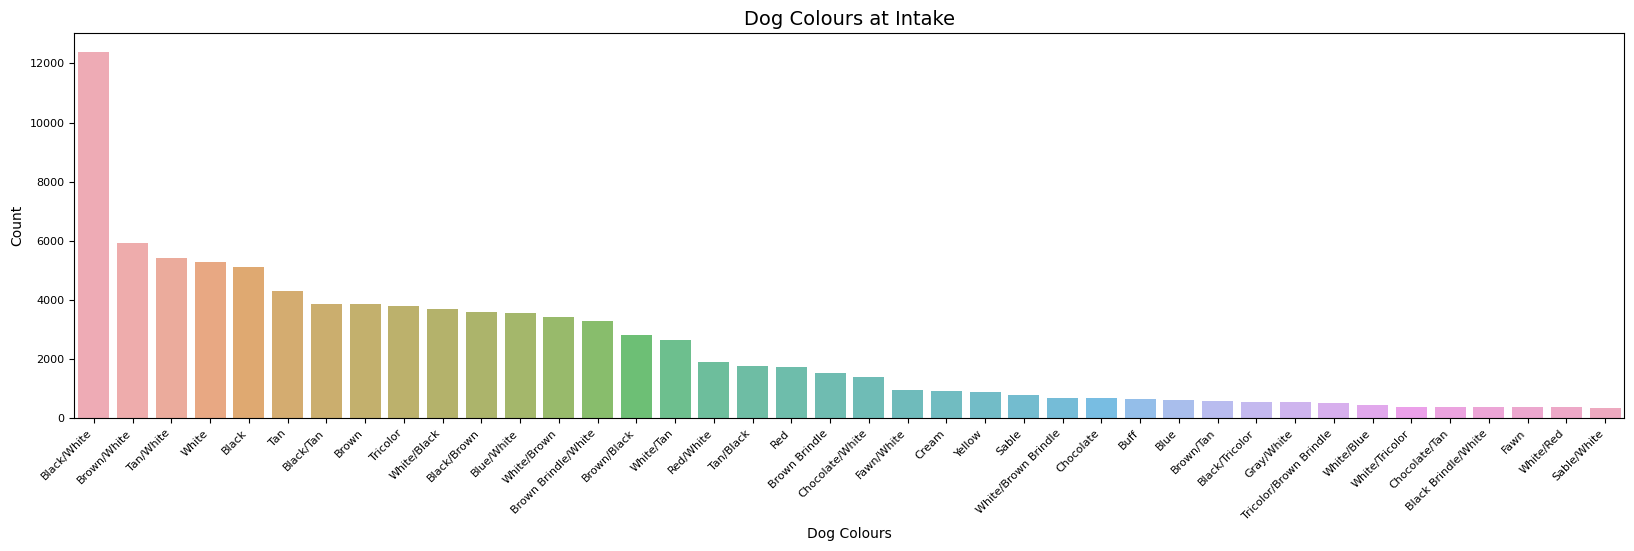

In [97]:
# Creating a bar chart to visualise Dog colours at intake:

plt.figure(figsize=(20,5))
sns.barplot(x=dogColourCount.index, y=dogColourCount.values, alpha = 0.8)
plt.title('Dog Colours at Intake', fontsize = 14)
plt.ylabel('Count', fontsize = 10)
plt.xlabel('Dog Colours', fontsize = 10)
plt.xticks(rotation = 45, ha = 'right', fontsize = 8) # reducing font size of x axis as there are 20 cat breeds to fit on plot
plt.yticks(fontsize = 8)
plt.show()

*Black/ White is the most common colour of dog to be given shelter.*

### 10.8. Calculating the average, median, main and max time it takes for animals to reach adoption. Then comparing this to statistics for other outcomes (transfer, etc.). Visualising the time-to-outcome distribution using box plots. Then repeating this, subsetting based on animal type.

In [98]:
# Calculate the average, median, min and max time it takes for animals to reach an outcome (adoption, transfer, etc.):

time_outcome_by_type = shelter_df.groupby(['Outcome Type'])['Time In Shelter'].agg(['mean', 'median', 'min', 'max'])

time_outcome_by_type

,mean,median,min,max
Outcome Type,,,,
Adoption,67.580046,17.0,0,3480
Died,27.614157,3.0,0,2218
Disposal,8.533426,0.0,0,934
Euthanasia,22.985766,0.0,0,3122
Missing,64.023810,42.5,0,441
Relocate,5.333333,1.0,0,44
Return to Owner,112.147417,3.0,0,3430
Stolen,798.300000,558.5,0,2163
Transfer,31.023348,4.0,0,3550


#### *Plotting boxplots to see distribution of time in shelter to outcome:*

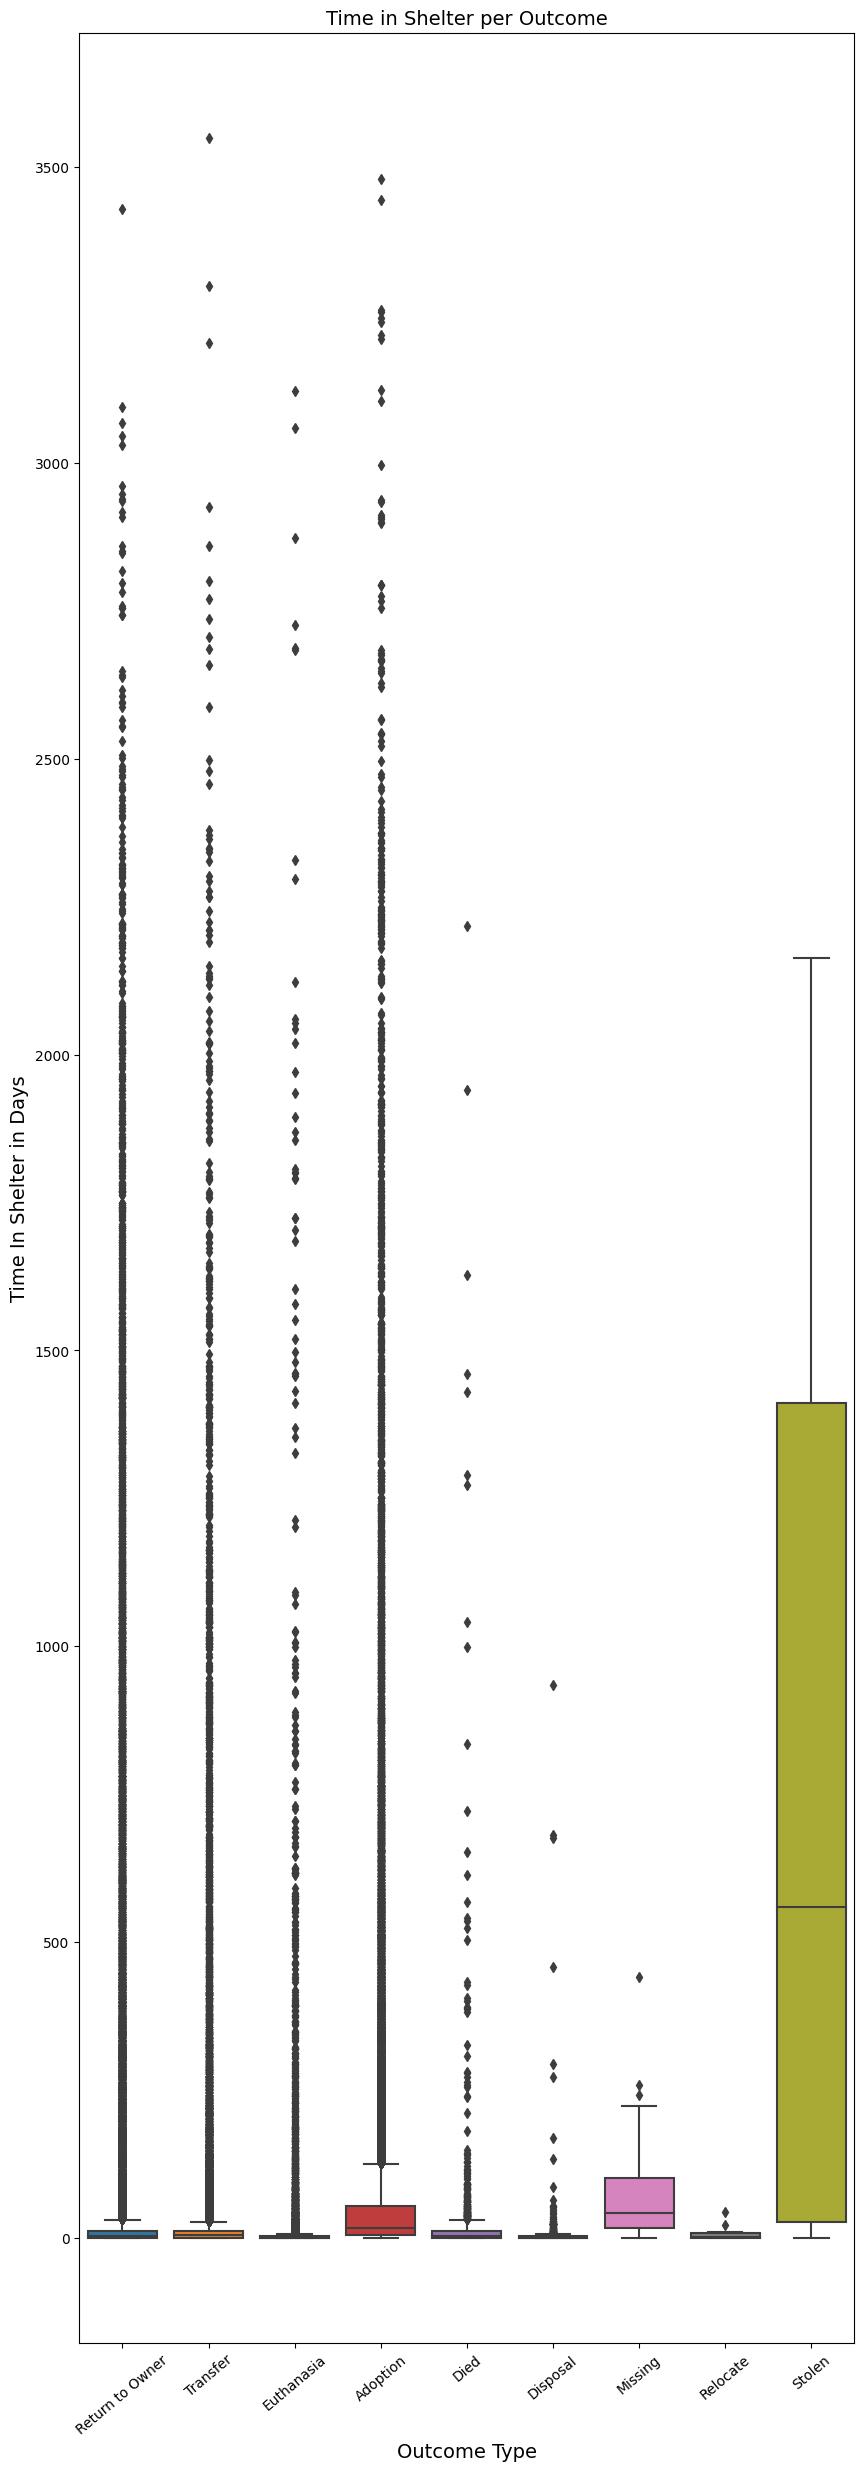

In [100]:
# Plotting boxplot:

plt.figure(figsize=(10, 30))
sns.boxplot(data=shelter_df, x='Outcome Type', y='Time In Shelter')
plt.xticks(rotation=40, fontsize = 10)
plt.yticks(rotation=0, fontsize = 10)
plt.xlabel('Outcome Type', fontsize = 14)
plt.ylabel('Time In Shelter in Days', fontsize = 14)
plt.title('Time in Shelter per Outcome', fontsize = 14)
plt.show()

*The bulk of stolen animals have spent up to around 1400 days in the shelter. For the rest of the outcomes, the majority of the animals do not spend as much time in the shelter in comparison. The majority of animals euthanised or who died spend very little time in the shelter.*

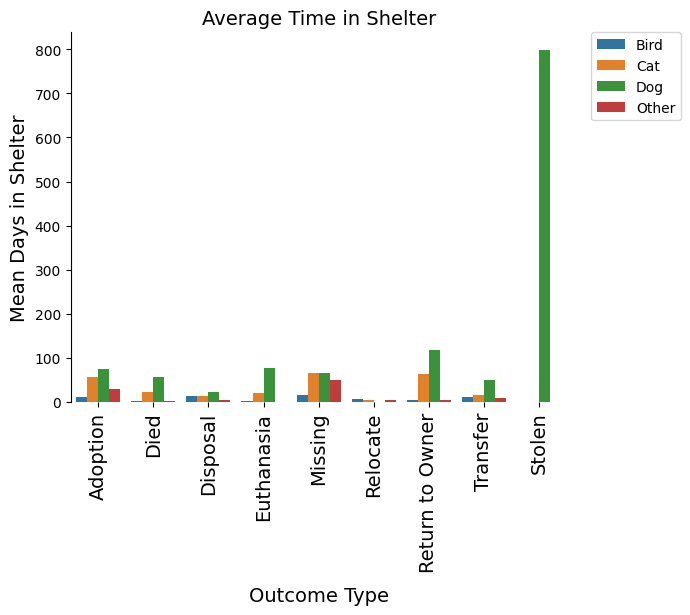

In [101]:
# plotting bar chart showing mean days per outcome:

animal_shelter_time = shelter_df.groupby(['Animal', 
                                      'Outcome Type'])['Time In Shelter'].mean().reset_index()

bar = sns.barplot(x='Outcome Type', y='Time In Shelter', 
                  hue='Animal', data=animal_shelter_time)

bar.set_title('Average Time in Shelter', fontsize=14)
bar.set_ylabel('Mean Days in Shelter', fontsize=14)
bar.set_xlabel('Outcome Type', fontsize=14)
bar.set_xticklabels(bar.get_xticklabels(), fontsize=14, rotation=90)
plt.yticks(size = 10)

bar.xaxis.labelpad = 10
sns.despine(bottom=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, prop={'size':10}, borderaxespad=0.)

# plt.tight_layout()
sns.despine(bottom=True)

*The average time spent in shelter for stolen dogs is very high and also seem to be the single animal type to be stolen.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


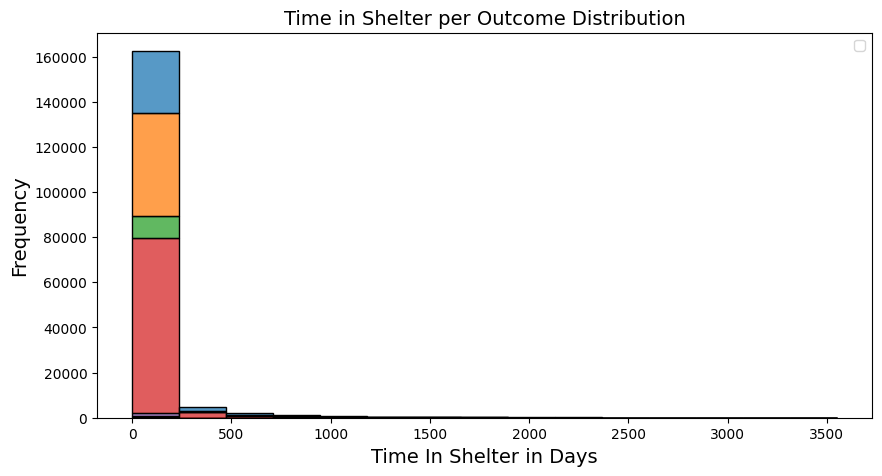

In [136]:
# Plotting histogram for time in shelter per outcome distribution:

plt.figure(figsize=(10, 5))
sns.histplot(data=shelter_df, x='Time In Shelter', hue='Outcome Type', multiple='stack', bins=15)
plt.xlabel('Time In Shelter in Days', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Time in Shelter per Outcome Distribution', fontsize = 14)
plt.legend(title = 'Outcome Type', title_fontsize = 14, fontsize = 10))
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

### 10.9. Comparing characteristics of animals (by animal type - cats, dogs) that were adopted versus those that had other outcomes. Characteristics to look at:  
Age range  
Breed (top 10 / bottom 10 breeds adopted)  
Mix vs purebred? (tbc)  
Size? (tbc)  
Sex  
neuter status  
Colour  
intake type  
condition at intake

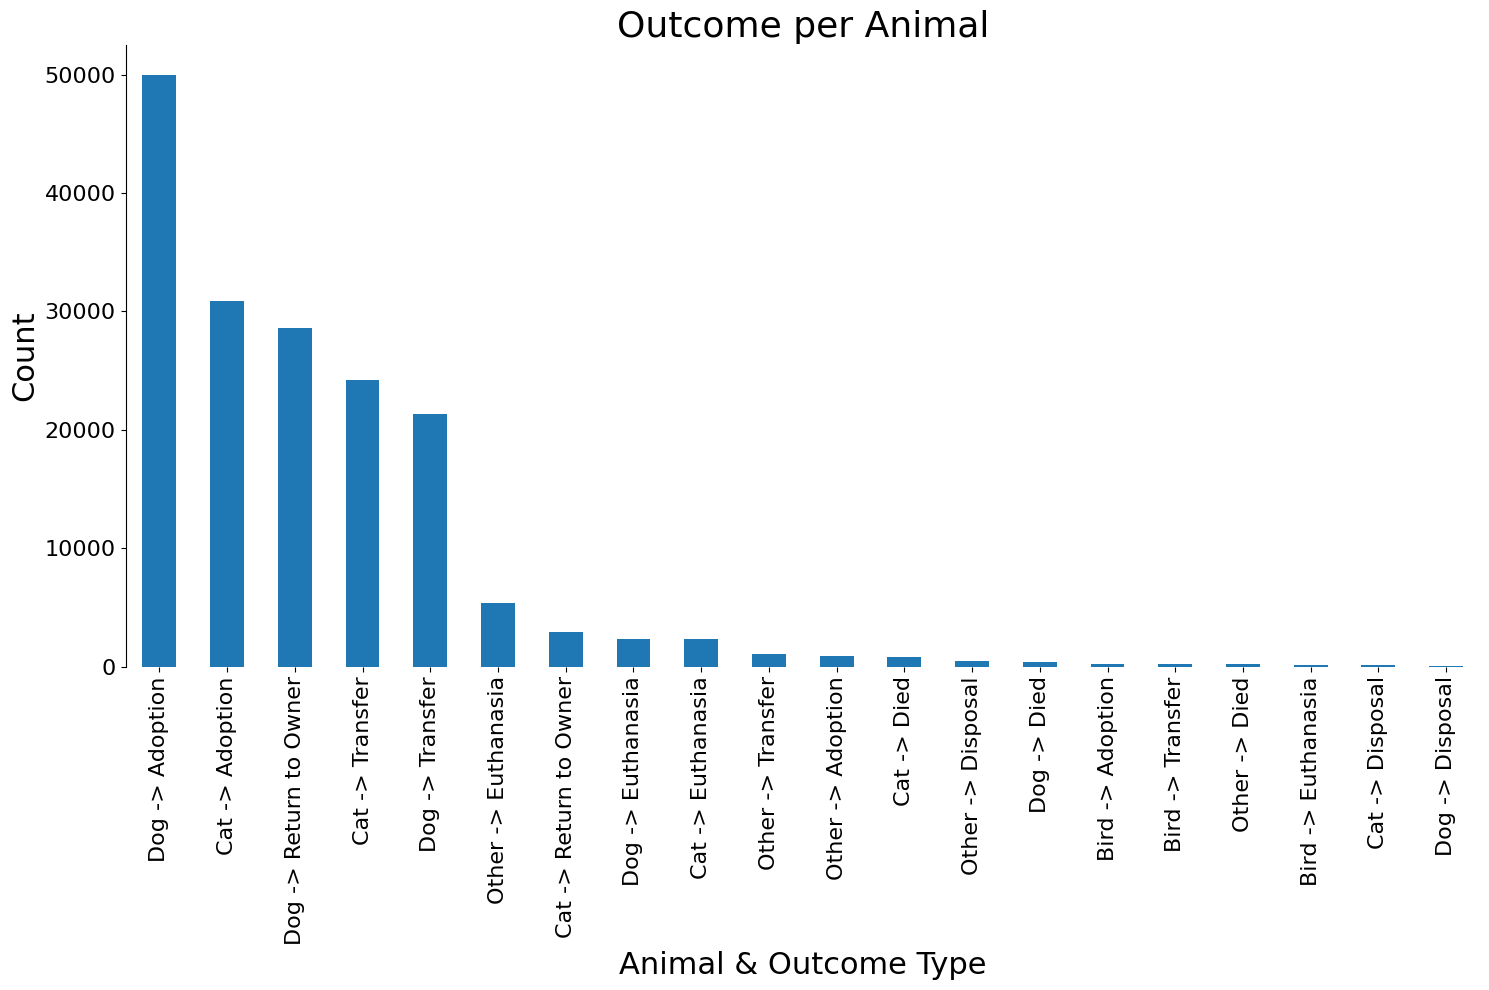

In [105]:
# visualise the distribution of Outcome Types for animals:


shelter_df['Animal Outcome'] = shelter_df['Animal'] + ' -> ' + shelter_df['Outcome Type']

intake_outcomes = shelter_df['Animal Outcome'].value_counts()[0:20].plot(kind='bar', 
                                                                     fontsize=16, 
                                                                     figsize=(15, 10))
intake_outcomes.set_ylabel('Count', fontsize=22)
intake_outcomes.set_xlabel('Animal & Outcome Type', fontsize=22)
intake_outcomes.set_title('Outcome per Animal', fontsize=26)

plt.tight_layout()
sns.despine(bottom=True)

*The most popular animal-to-outcome occurences are dog-to-adoption, cat-to-adoption and dog-to-return-to-owner.*

In [106]:
shelter_df['Age Days Outcome'] = shelter_df['Age at Outcome'].dt.days

<Figure size 1000x600 with 0 Axes>

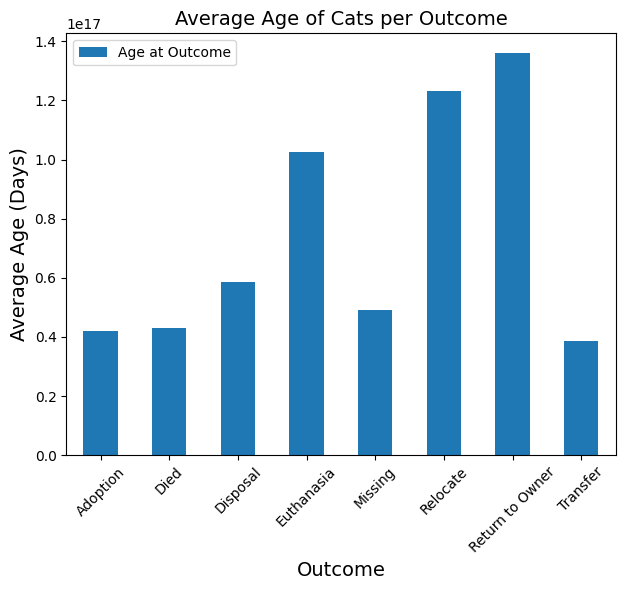

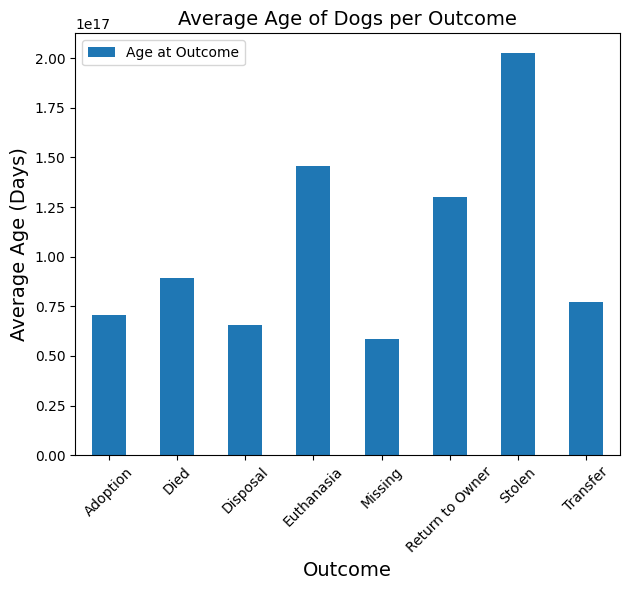

In [107]:
# Creating a bar plot to visualise age of cats and dogs with outcomes:

plt.figure(figsize = (10,6))

# seperate data for Cats and Dogs:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

aveOutcomeCatsAge = catsData.groupby('Outcome Type')['Age at Outcome'].mean()
aveOutcomeDogsAge = dogsData.groupby('Outcome Type')['Age at Outcome'].mean()
# aveOutcomeAge = aveOutcomeAge.unstack()

# plotting seperate bar charts for Cats and Dogs:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
aveOutcomeCatsAge.plot(kind = 'bar')
plt.xlabel('Outcome', fontsize = 14)
plt.ylabel('Average Age (Days)', fontsize = 14)
plt.title('Average Age of Cats per Outcome', fontsize = 14)
plt.legend()
plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 2)
aveOutcomeDogsAge.plot(kind = 'bar')
plt.xlabel('Outcome', fontsize = 14)
plt.ylabel('Average Age (Days)', fontsize = 14)
plt.title('Average Age of Dogs per Outcome', fontsize = 14)
plt.legend()
plt.xticks(rotation = 45, fontsize = 10)
plt.yticks(rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()

*Older cats are most likely to reolcate, be returned to owner or be euthanised. Older dogs are more likely to be stolen, euthanised or return to owner*

### Plotting chart for Breed of Cat per Outcome:

In [108]:
# View all Cat breed:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Breed'].value_counts())

,count
Breed,
Domestic Shorthair Mix,34587
Domestic Shorthair,16016
Domestic Medium Hair Mix,3434
Domestic Longhair Mix,1751
Domestic Medium Hair,1548
...,...
Domestic Longhair/Russian Blue,1
Turkish Angora,1
Snowshoe/Siamese,1


<Figure size 1200x600 with 0 Axes>

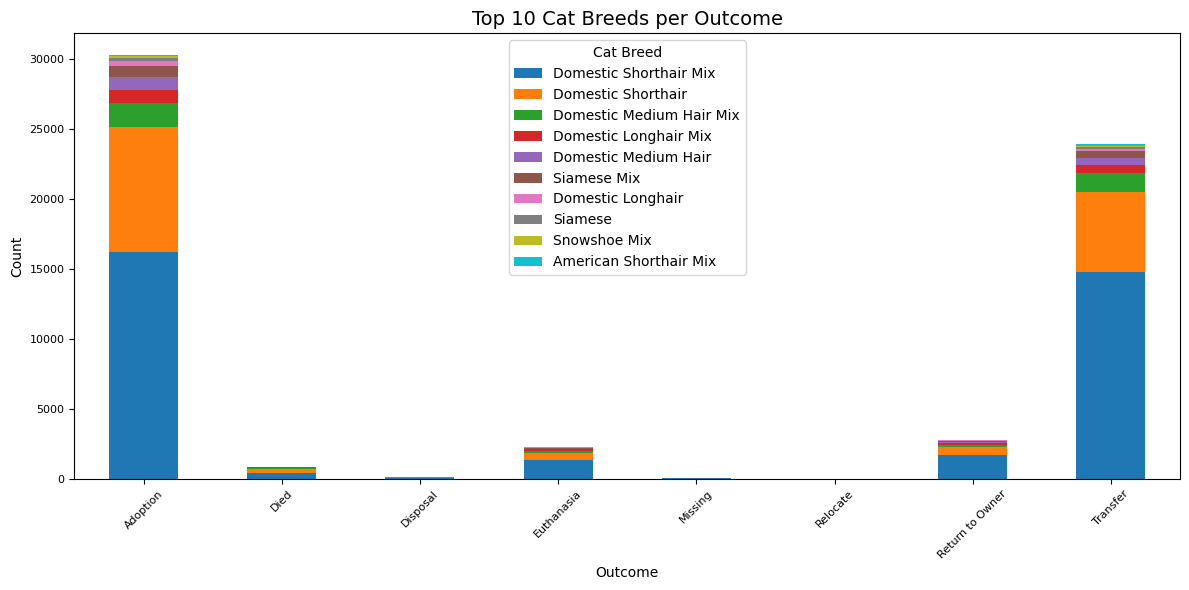

In [109]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catBreedOutcomeCount = catsData.groupby(['Outcome Type', 'Breed']).size().unstack()

#to bring up the first 10 most popular breeds as there are numerous ones
catBreedTen = catBreedOutcomeCount.sum().nlargest(10).index

# filtering breed counts to calcultae top 10 breeds:
catBreedTenCount = catBreedOutcomeCount[catBreedTen]

# plot bar chart for top 10 Cat breed counts per outcome:

plt.figure(figsize=(12,6))
catBreedTenCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Top 10 Cat Breeds per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8) # reducing font size of x axis as there are 20 cat breeds to fit on plot
plt.yticks(fontsize = 8)
plt.legend(title = 'Cat Breed')
plt.tight_layout()
plt.show()

*Domestic shorthair mix and domestic shorthair are the most common cat breeds to be transferred or adopted.*

### Plotting chart for Sex of Cat per Outcome:

In [110]:
# View all Cat sex types:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Sex'].value_counts())

# We can see there are only 3 categories for sex of Cats.

,count
Sex,
Female,28905
Male,28210
Unknown,4217


<Figure size 1200x600 with 0 Axes>

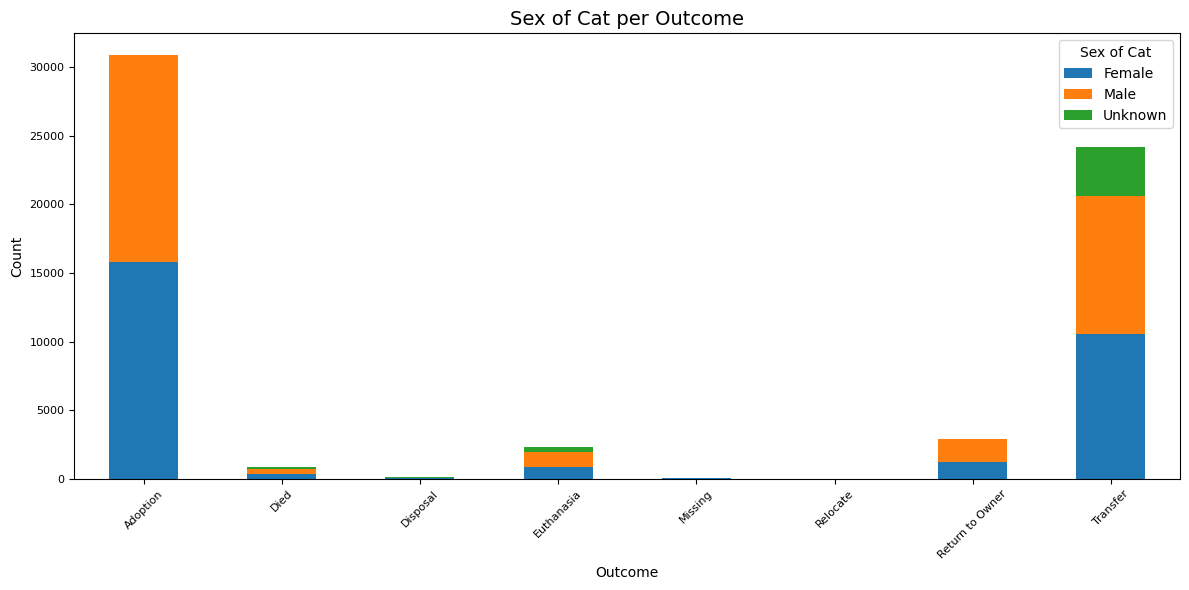

In [111]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catSexOutcomeCount = catsData.groupby(['Outcome Type', 'Sex']).size().unstack()

#to bring up the first 3 sex types as there are are only 3 (male, female and unkown):
catSexType = catSexOutcomeCount.sum().nlargest(3).index

# filtering Sex type counts to calculate sexes:
catSexCount = catSexOutcomeCount[catSexType]

# plot bar chart for the three Sex type counts per outcome:

plt.figure(figsize=(12,6))
catSexCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Sex of Cat per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Sex of Cat')
plt.tight_layout()
plt.show()

*Both male and female cats are more likely to be transferred or adopted.*

### Plotting chart for Neuter Status at Outcome of Cat per Outcome:

In [112]:
# View all Cat Neuter Status at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Neuter Status at Outcome'].value_counts())

# we can see there are only 4 categories for Neuter Status at Outcome.

,count
Neuter Status at Outcome,
Neutered,19667
Spayed,19485
Intact,17963
Unknown,4217


<Figure size 1200x600 with 0 Axes>

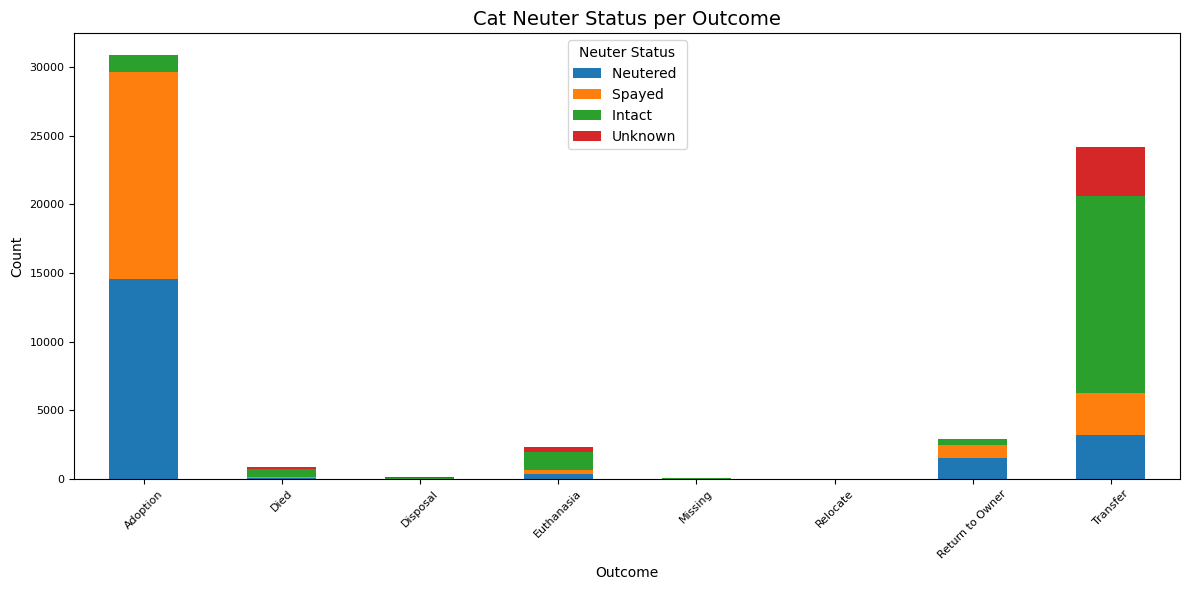

In [113]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catNeuterOutcomeCount = catsData.groupby(['Outcome Type', 'Neuter Status at Outcome']).size().unstack()

#to bring up the 4 Neuter statuses:
catNeuter = catNeuterOutcomeCount.sum().nlargest(4).index

# filtering Neuter counts to calculate Neuter statuses:
catNeuterCount = catNeuterOutcomeCount[catNeuter]

# plot bar chart for the 4 Neuter statuses per outcome:

plt.figure(figsize=(12,6))
catNeuterCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Cat Neuter Status per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Neuter Status', loc = 'upper center')
plt.tight_layout()
plt.show()

*Neutured and splayed cats are most likely to be adopted. Intact cats are more likely to be transferred.*

### Plotting chart for Colour of Cat per Outcome:

In [114]:
# View all Cat Colour at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Colour'].value_counts())

,count
Colour,
Brown Tabby,9282
Black,7972
Black/White,5551
Brown Tabby/White,4872
Orange Tabby,4486
...,...
Blue Smoke/Gray,1
Black/Seal Point,1
Seal Point/Gray,1


In [115]:
# we can see there are numerous categories for Colour at Outcome so we will select the top 20.

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Colour'].value_counts().head(20))

,count
Colour,
Brown Tabby,9282
Black,7972
Black/White,5551
Brown Tabby/White,4872
Orange Tabby,4486
Tortie,2817
Calico,2705
Blue Tabby,2484
Blue,2318


<Figure size 1200x600 with 0 Axes>

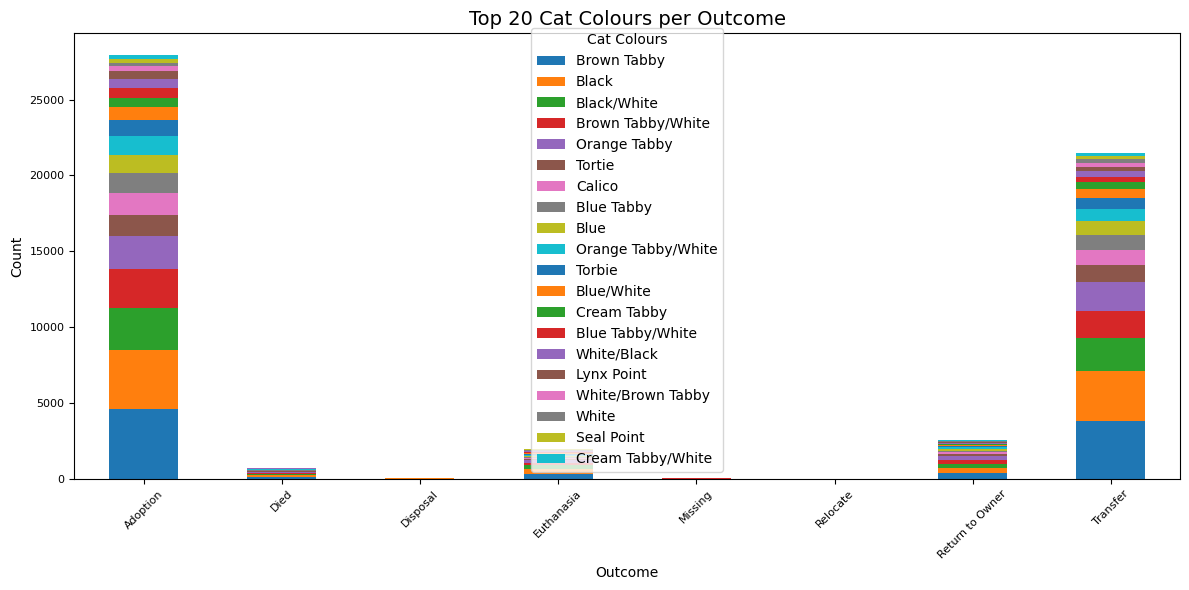

In [116]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catColourOutcomeCount = catsData.groupby(['Outcome Type', 'Colour']).size().unstack()

#to bring up the top 20 colours of Cats:
catColourTwenty = catColourOutcomeCount.sum().nlargest(20).index

# filtering Colour counts to calculate Cat Colours:
catColourTwentyCount = catColourOutcomeCount[catColourTwenty]

# plot bar chart for the top 20 Cat colours per outcome:

plt.figure(figsize=(12,6))
catColourTwentyCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Top 20 Cat Colours per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8) # reducing font size of x axis as there are 20 cat colours to fit on plot
plt.yticks(fontsize = 8)
plt.legend(title = 'Cat Colours', loc = 'best')
plt.tight_layout()
plt.show()

*Torbie, Blue/ White and Cream Tabby cats are more lekly to be adopted or transferred.*

### Plotting chart for Intake Type of Cat per Outcome:

In [117]:
# View all Cat Intake Type at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Intake Type'].value_counts())

# we can see there are only 5 categories for Intake type so we will include this in our plotting code.

,count
Intake Type,
Stray,46677
Owner Surrender,12702
Public Assist,1368
Abandoned,522
Euthanasia Request,63


<Figure size 1200x600 with 0 Axes>

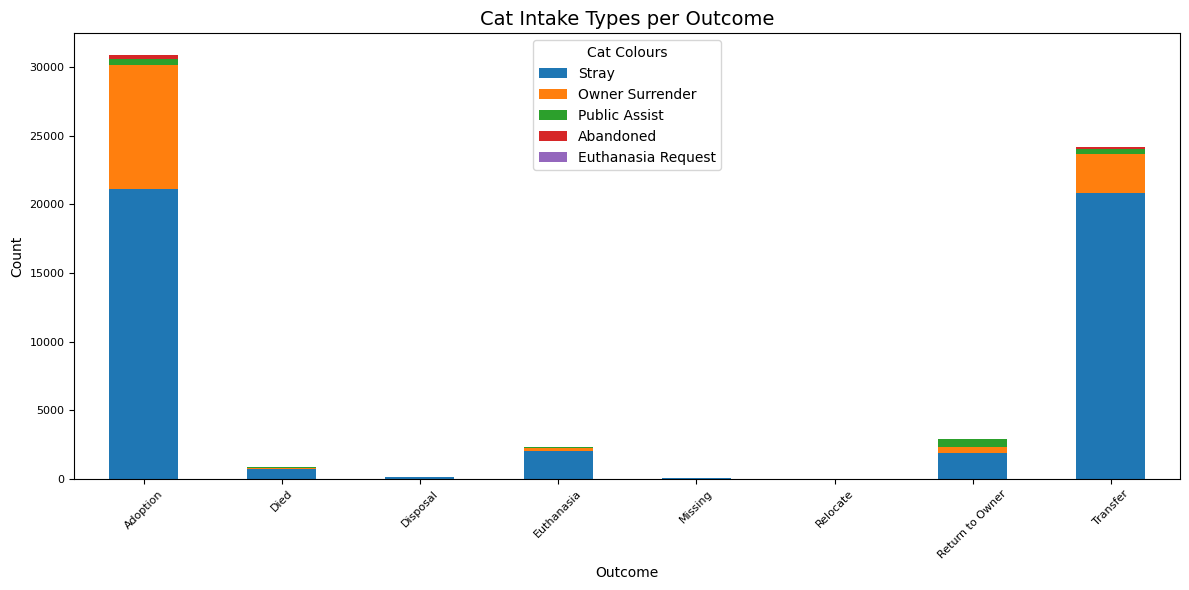

In [118]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catIntakeOutcomeCount = catsData.groupby(['Outcome Type', 'Intake Type']).size().unstack()

#to bring up the top 5 Intake Types for Cats:
catIntake = catIntakeOutcomeCount.sum().nlargest(5).index

# filtering Intake Type counts to calculate Cat Intake Types:
catIntakeCount = catIntakeOutcomeCount[catIntake]

# plot bar chart for the 5 Intake Types per outcome:

plt.figure(figsize=(12,6))
catIntakeCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Cat Intake Types per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Cat Colours', loc = 'best')
plt.tight_layout()
plt.show()

*Both stray and owner-surrenderred cats are more likely to be adopted or transferred.*

### Plotting chart for Intake Condition of Cat per Outcome:

In [119]:
# View all Cat Intake Conditions at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Cat']['Intake Condition'].value_counts())

# we can see there are numerous categories for Intake type so we will focus on the top 20.

,count
Intake Condition,
Normal,51329
Injured,3702
Sick,2682
Nursing,2563
Neonatal,617
Feral,132
Other,103
Aged,69
Medical,68


<Figure size 1200x600 with 0 Axes>

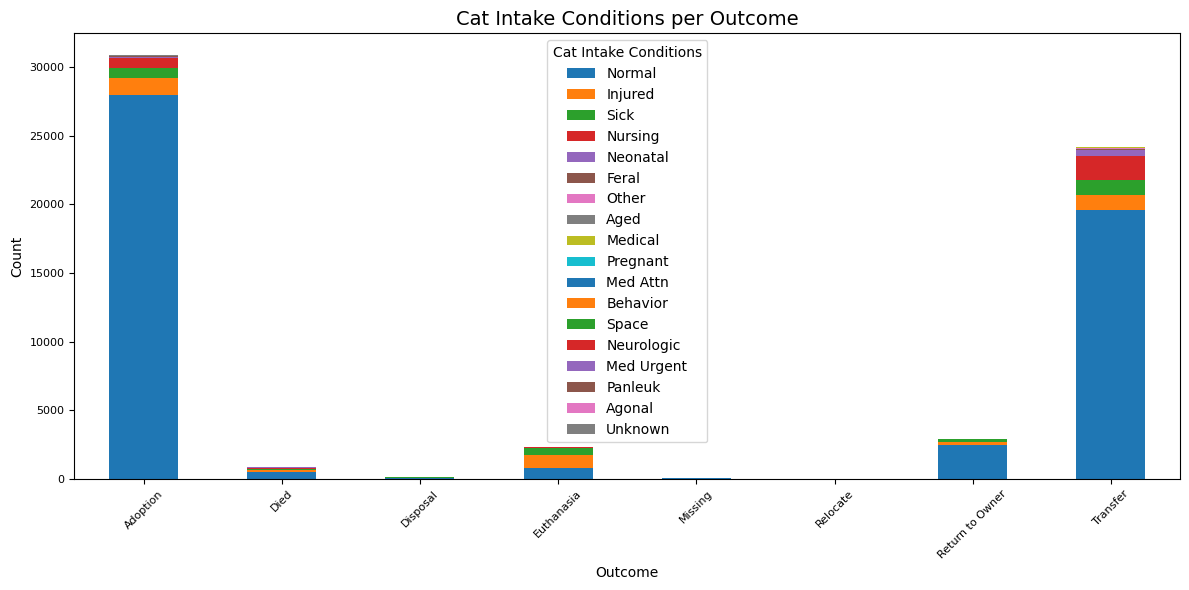

In [120]:
# seperate data for Cats:
catsData = shelter_df[shelter_df['Animal'] == 'Cat']

# generate Cat and Outcome Type row value counts into a variable:
catIntakeConditionOutcomeCount = catsData.groupby(['Outcome Type', 'Intake Condition']).size().unstack()

#to bring up the top 20 Intake Conditions for Cats:
catIntakeCondition = catIntakeConditionOutcomeCount.sum().nlargest(20).index

# filtering Intake Condition counts to calculate Cat Intake Conditions:
catIntakeConditionCount = catIntakeConditionOutcomeCount[catIntakeCondition]

# plot bar chart for top 20 Intake Conditions per outcome:

plt.figure(figsize=(12,6))
catIntakeConditionCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Cat Intake Conditions per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Cat Intake Conditions', loc = 'upper center')
plt.tight_layout()
plt.show()

*Cats with normal conditions are more likely to be adopted ot transferred.*

### Plotting chart for Breed of Dog per Outcome:

In [121]:
# View all Dog breeds:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Breed'].value_counts())

,count
Breed,
Pit Bull Mix,12644
Labrador Retriever Mix,9729
Chihuahua Shorthair Mix,7445
German Shepherd Mix,4473
Pit Bull,3064
...,...
Collie Rough/Pointer,1
Australian Shepherd/Collie Smooth,1
Whippet/Catahoula,1


<Figure size 1200x600 with 0 Axes>

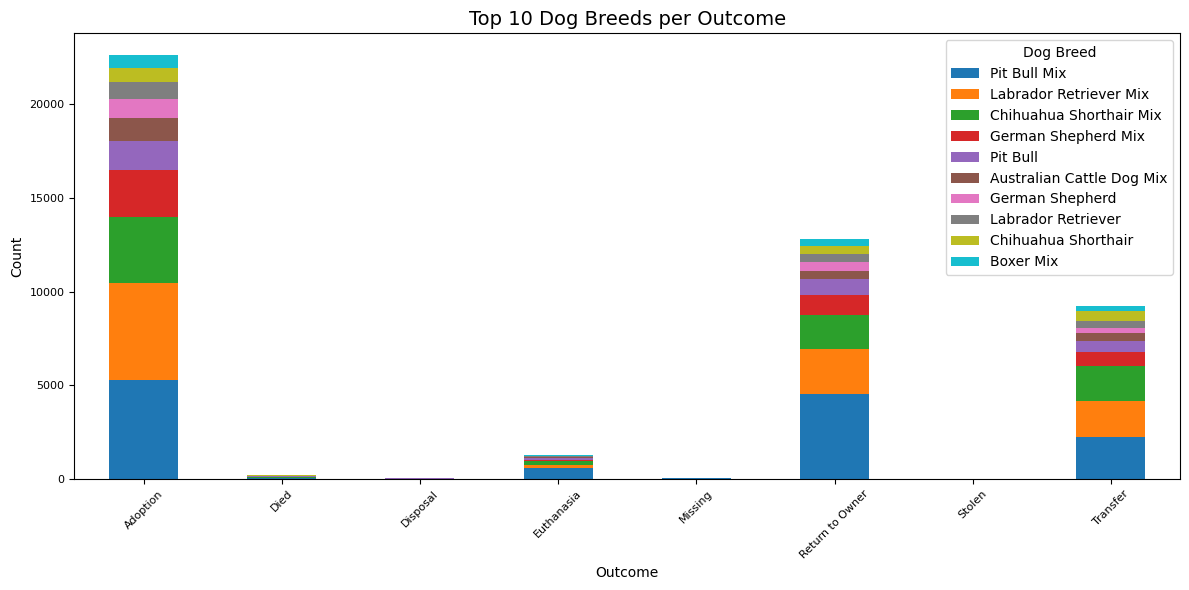

In [122]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogBreedOutcomeCount = dogsData.groupby(['Outcome Type', 'Breed']).size().unstack()

#to bring up the first 10 most popular breeds as there are numerous ones
dogBreedTen = dogBreedOutcomeCount.sum().nlargest(10).index

# filtering breed counts to calculate top 10 breeds:
dogBreedTenCount = dogBreedOutcomeCount[dogBreedTen]

# plot bar chart for top 10 Dog breed counts per outcome:

plt.figure(figsize=(12,6))
dogBreedTenCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Top 10 Dog Breeds per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8) # reducing font size of x axis as there are 10 dog breeds to fit on plot
plt.yticks(fontsize = 8)
plt.legend(title = 'Dog Breed')
plt.tight_layout()
plt.show()

*Pit Bull Mix, Labrador Retriever Mix and Chihuahua Shorthair Mix are more likely to be adopted, transferred or returned to owner which is expected as they are the most common breeds of dog being given shelter as seen earlier.*

### Plotting chart for Sex of Dog per Outcome:

In [123]:
# View all Dog sex types:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Sex'].value_counts())

# We can see there are only 3 categories for sex of Dogs.

,count
Sex,
Male,55681
Female,46438
Unknown,581


<Figure size 1200x600 with 0 Axes>

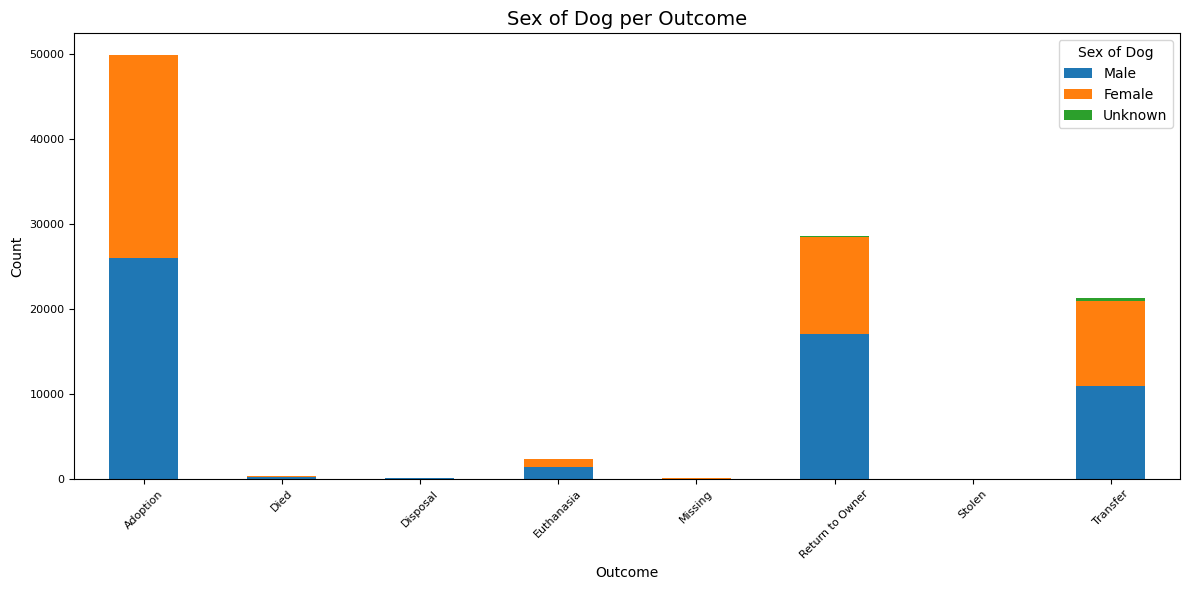

In [124]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogSexOutcomeCount = dogsData.groupby(['Outcome Type', 'Sex']).size().unstack()

#to bring up the first 3 sex types as there are are only 3 (male, female and unkown):
dogSexType = dogSexOutcomeCount.sum().nlargest(3).index

# filtering Sex type counts to calculate sexes:
dogSexCount = dogSexOutcomeCount[dogSexType]

# plot bar chart for the three Sex type counts per outcome:

plt.figure(figsize=(12,6))
dogSexCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Sex of Dog per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8) 
plt.yticks(fontsize = 8)
plt.legend(title = 'Sex of Dog')
plt.tight_layout()
plt.show()

*Both male and female dogs are more likely to be adopted, transferred or returned to owner.*

### Plotting chart for Neuter Status at Outcome of Dog per Outcome:

In [125]:
# View all Dog Neuter Status at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Neuter Status at Outcome'].value_counts())

# we can see there are only 4 categories for Neuter Status at Outcome.

,count
Neuter Status at Outcome,
Neutered,44643
Spayed,36923
Intact,20553
Unknown,581


<Figure size 1200x600 with 0 Axes>

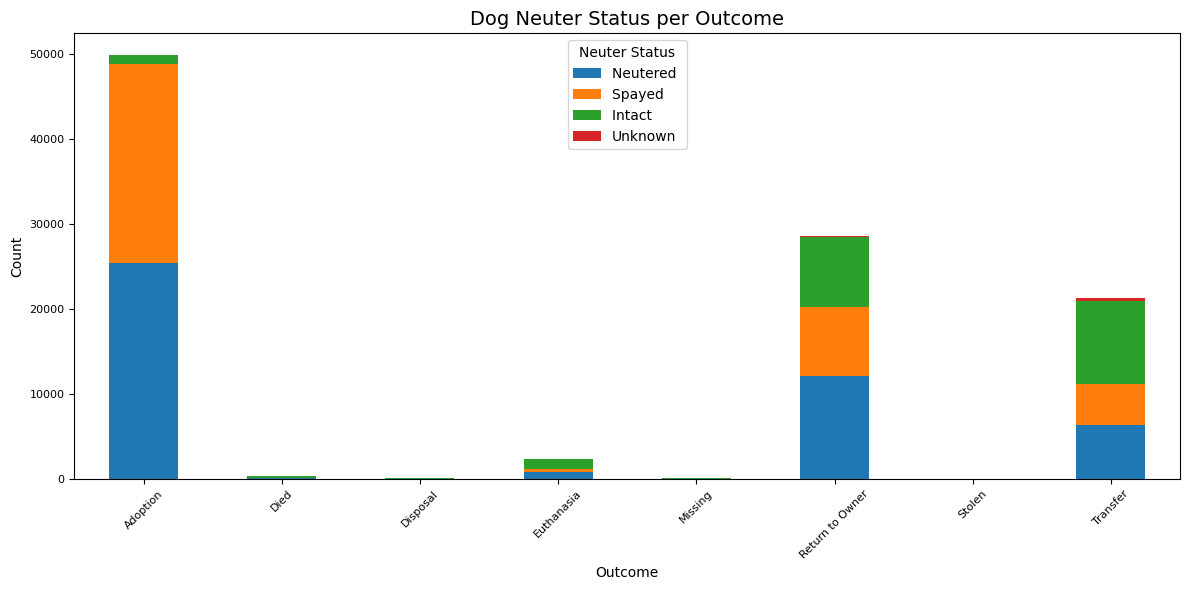

In [126]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogNeuterOutcomeCount = dogsData.groupby(['Outcome Type', 'Neuter Status at Outcome']).size().unstack()

#to bring up the 4 Neuter statuses:
dogNeuter = dogNeuterOutcomeCount.sum().nlargest(4).index

# filtering Neuter counts to calculate Neuter statuses:
dogNeuterCount = dogNeuterOutcomeCount[dogNeuter]

# plot bar chart for the 4 Neuter statuses per outcome:

plt.figure(figsize=(12,6))
dogNeuterCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Dog Neuter Status per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Neuter Status', loc = 'upper center')
plt.tight_layout()
plt.show()

*Neutured and spayed dogs are more likely to be adopted. Intact dogs are mre likely to be transferred. A good proportion of neutured, spayed and intact dogs are returned to their owner.*

### Plotting chart for Colour of Dog per Outcome:

In [127]:
# View all Dog Colour at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Colour'].value_counts())

,count
Colour,
Black/White,12397
Brown/White,5919
Tan/White,5429
White,5286
Black,5117
...,...
Black Smoke/Blue Tick,1
White/Tortie,1
Black/Gold,1


In [128]:
# we can see there are numerous categories for Colour at Outcome so we will select the top 20.

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Colour'].value_counts().head(20))

,count
Colour,
Black/White,12397
Brown/White,5919
Tan/White,5429
White,5286
Black,5117
Tan,4320
Black/Tan,3873
Brown,3852
Tricolor,3799


<Figure size 1200x600 with 0 Axes>

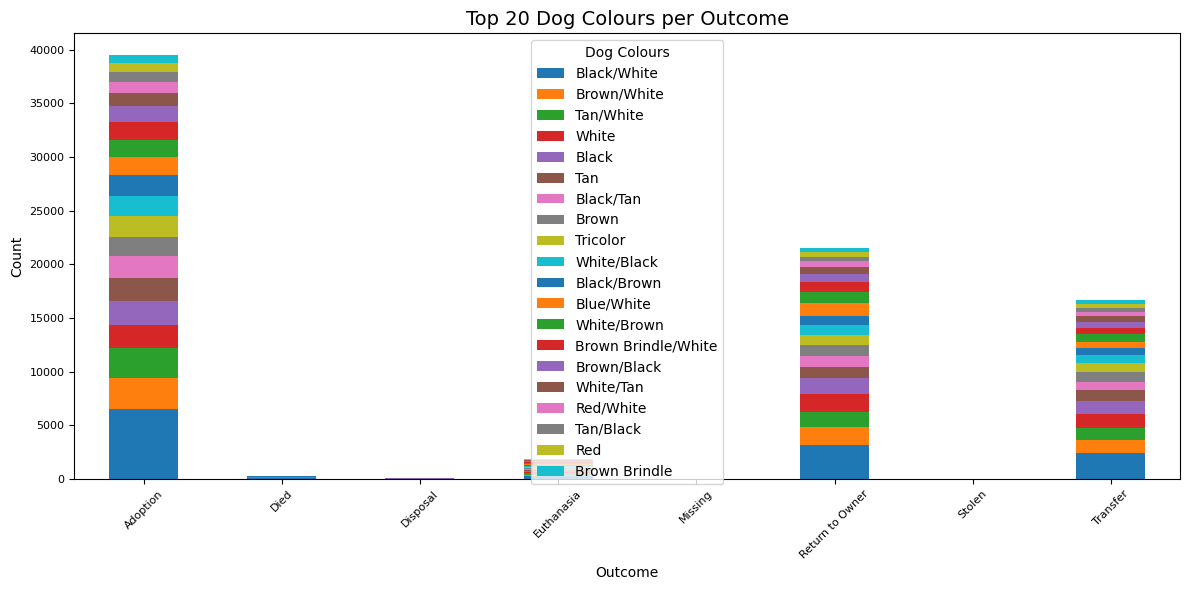

In [129]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogColourOutcomeCount = dogsData.groupby(['Outcome Type', 'Colour']).size().unstack()

#to bring up the top 20 colours of Dogs:
dogColourTwenty = dogColourOutcomeCount.sum().nlargest(20).index

# filtering Colour counts to calculate Dog Colours:
dogColourTwentyCount = dogColourOutcomeCount[dogColourTwenty]

# plot bar chart for the top 20 Dog colours per outcome:

plt.figure(figsize=(12,6))
dogColourTwentyCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Top 20 Dog Colours per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Dog Colours', loc = 'upper center')
plt.tight_layout()
plt.show()

*Black and white dogs are more likely to be adopted, returned to owner or transferred.*

### Plotting chart for Intake Type of Dog per Outcome:

In [130]:
# View all Dog Intake Type at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Intake Type'].value_counts())

# we can see there are only 6 categories for Intake type so we will include this in our plotting code.

,count
Intake Type,
Stray,70097
Owner Surrender,22044
Public Assist,9673
Abandoned,698
Euthanasia Request,187
Wildlife,1


<Figure size 1200x600 with 0 Axes>

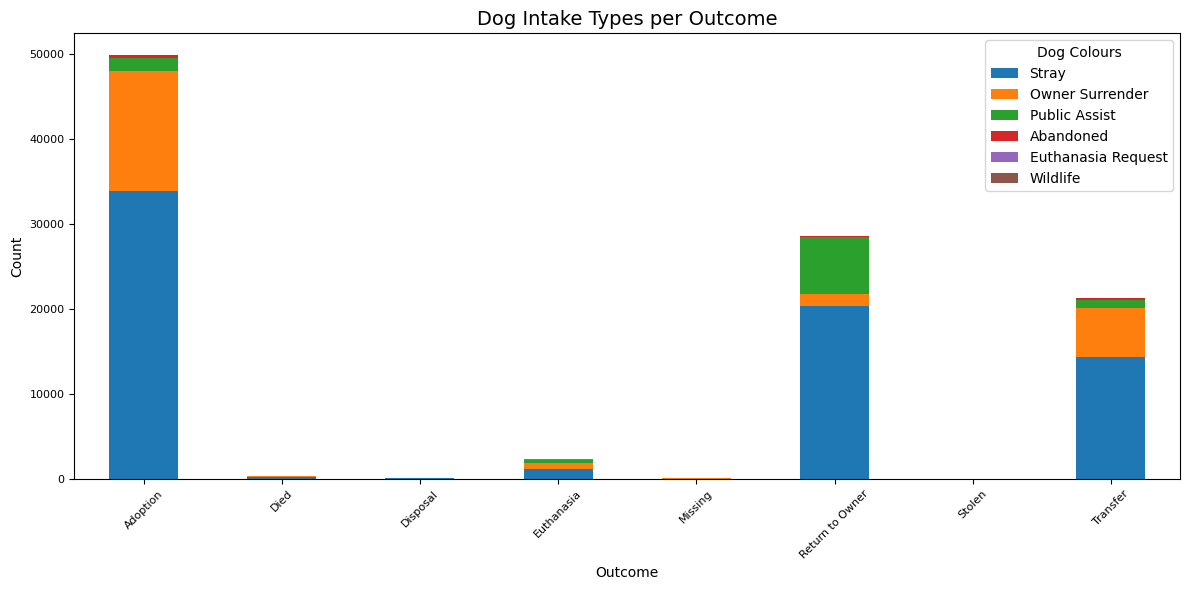

In [131]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogIntakeOutcomeCount = dogsData.groupby(['Outcome Type', 'Intake Type']).size().unstack()

#to bring up the top 6 Intake Types for Dogs:
dogIntake = dogIntakeOutcomeCount.sum().nlargest(6).index

# filtering Intake Type counts to calculate Dog Intake Types:
dogIntakeCount = dogIntakeOutcomeCount[dogIntake]

# plot bar chart for the 5 Intake Types per outcome:

plt.figure(figsize=(12,6))
dogIntakeCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Dog Intake Types per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Dog Colours', loc = 'best')
plt.tight_layout()
plt.show()

*Stray dogs are more likely to be adopted, returned to owner or transferred. Owner-surrenderred cats are more likely to be adopted.*

### Plotting chart for Intake Condition of Dog per Outcome:

In [132]:
# View all Dog Intake Conditions at Outcome:

pd.DataFrame(shelter_df.loc[shelter_df['Animal'] == 'Dog']['Intake Condition'].value_counts())

# we can see there are numerous categories for Intake type so we will focus on the top 20.

,count
Intake Condition,
Normal,93246
Injured,4474
Sick,2340
Nursing,1273
Aged,451
Neonatal,284
Other,240
Medical,198
Pregnant,97


<Figure size 1200x600 with 0 Axes>

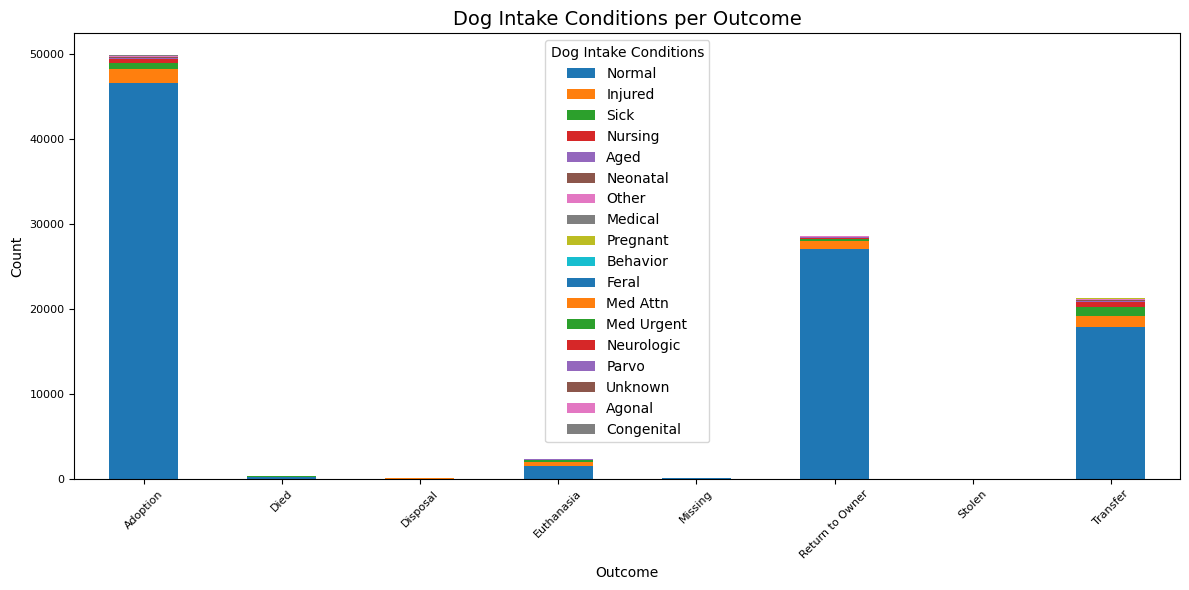

In [133]:
# seperate data for Dogs:
dogsData = shelter_df[shelter_df['Animal'] == 'Dog']

# generate Dog and Outcome Type row value counts into a variable:
dogIntakeConditionOutcomeCount = dogsData.groupby(['Outcome Type', 'Intake Condition']).size().unstack()

#to bring up the top 20 Intake Conditions for Dogs:
dogIntakeCondition = dogIntakeConditionOutcomeCount.sum().nlargest(20).index

# filtering Intake Condition counts to calculate Dog Intake Conditions:
dogIntakeConditionCount = dogIntakeConditionOutcomeCount[dogIntakeCondition]

# plot bar chart for top 20 Intake Conditions per outcome:

plt.figure(figsize=(12,6))
dogIntakeConditionCount.plot(kind = 'bar', stacked = True, figsize = (12, 6))
plt.title('Dog Intake Conditions per Outcome', fontsize = 14)
plt.xlabel('Outcome', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.xticks(rotation = 45, fontsize = 8)
plt.yticks(fontsize = 8)
plt.legend(title = 'Dog Intake Conditions', loc = 'upper center')
plt.tight_layout()
plt.show()

*Dogs with normal conditions are most likely to be adopted, returned to owner or transferred.*